In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/turnover-forecast/TurnoverData_2018.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime as dt
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import grangercausalitytests
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Granger causality test between two time series variable
def granger_test(df):
    df.columns = ['Month','x','y']
    tmpdf = pd.DataFrame(df[['y','x']].iloc[:-12].values, 
                     columns=["y",'x'],index= df['Month'].iloc[:-12])
    max_lag = 8 

    result = grangercausalitytests(tmpdf[["y",'x']], max_lag, verbose=True)

    for lag in range(1, max_lag + 1):
        p_value = result[lag][0]['ssr_ftest'][1]
        if p_value < 0.05:  
            print(f"Lag {lag}: Feature Granger causes Target (p-value: {p_value:.4f})")
        else:
            print(f"Lag {lag}: Feature does not Granger cause Target (p-value: {p_value:.4f})")
    return tmpdf.copy()

In [4]:
from statsmodels.tsa.stattools import adfuller

# To check for stationarity
def adfuller_test(series):
    result = adfuller(series)

    # Extract and print the ADF test results
    adf_statistic = result[0]
    p_value = result[1]
    critical_values = result[4]

    print(f'ADF Statistic: {adf_statistic:.4f}')
    print(f'p-value: {p_value:.4f}')
    print('Critical Values:')
    for key, value in critical_values.items():
        print(f'   {key}: {value:.4f}')

    # Interpret the results
    if p_value <= 0.05:
        print("Result: Series is stationary (reject null hypothesis)")
    else:
        print("Result: Series is non-stationary (fail to reject null hypothesis)")

In [5]:
df_orig = pd.read_csv('/kaggle/input/turnover-forecast/TurnoverData_2018.csv')
df = df_orig.copy()

In [6]:
df.head()

,Month,AUS_GDP_AUD,AUS_Turnover_eur,BRA_Produced_automotives,BRA_GDP_eur,BRA_Turnover_eur,CAN_GDP_USD,CAN_Turnover_eur,CHN_GDP_EUR,CHN_Turnover_eur,...,JP_Machine_orders_in_mil_Yen,JP_GDP_eur,JP_Turnover_eur,NED_Producer_confidence,NED_GDP_eur,NED_Turnover_eur,SWE_GDP_EUR,SWE_Turnover_eur,USA_GDP_USD,USA_Turnover_eur
0,01-Jan-2000,286832000000,9.971484e+05,NaN,NaN,NaN,133500000000,211805.085232,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68440000000,1.695075e+06,992600000000,4.275446e+06
1,01-Feb-2000,286832000000,1.419504e+06,NaN,NaN,NaN,133400000000,242560.803337,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68440000000,1.722812e+06,999600000000,4.433853e+06
2,01-Mar-2000,286832000000,1.581805e+06,NaN,NaN,NaN,134100000000,239530.021705,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,68440000000,2.101717e+06,1009000000000,4.277618e+06
3,01-Apr-2000,289480000000,1.254553e+06,NaN,NaN,NaN,134600000000,518900.051752,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,72340000000,1.908211e+06,1022000000000,3.592345e+06
4,01-May-2000,289480000000,1.628677e+06,NaN,NaN,NaN,134900000000,348716.985292,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,72340000000,2.374561e+06,1023000000000,4.239386e+06


In [7]:
# Converting Month to timestamp
df['Month'] = df['Month'].apply(lambda date: dt.strptime(date,'%d-%b-%Y'))

In [8]:
df.columns

Index(['Month', 'AUS_GDP_AUD', 'AUS_Turnover_eur', 'BRA_Produced_automotives',
       'BRA_GDP_eur', 'BRA_Turnover_eur', 'CAN_GDP_USD', 'CAN_Turnover_eur',
       'CHN_GDP_EUR', 'CHN_Turnover_eur', 'ESP_GDP_EUR', 'ESP_Turnover_eur',
       'FRA_GDP_EUR', 'FRA_Turnover_eur', 'GBR_GDP_Pfund', 'GBR_Turnover_eur',
       'GBR_Manufactoring_Production', 'GER_ifo_Geschaeftsklima',
       'GER_ifo_Geschaeftslage', 'GER_ifo_Geschaeftserwartungen',
       'GER_GDP_eur', 'GER_Turnover_eur', 'ITA_GDP_EUR', 'ITA_Turnover_eur',
       'JP_Machine_orders_in_mil_Yen', 'JP_GDP_eur', 'JP_Turnover_eur',
       'NED_Producer_confidence', 'NED_GDP_eur', 'NED_Turnover_eur',
       'SWE_GDP_EUR', 'SWE_Turnover_eur', 'USA_GDP_USD', 'USA_Turnover_eur'],
      dtype='object')

In [9]:
aus = df[['Month', 'AUS_GDP_AUD', 'AUS_Turnover_eur']]
bra = df[['Month','BRA_Produced_automotives','BRA_GDP_eur', 'BRA_Turnover_eur']]
can = df[['Month', 'CAN_GDP_USD', 'CAN_Turnover_eur']]
chn = df[['Month','CHN_GDP_EUR', 'CHN_Turnover_eur']]
esp = df[['Month', 'ESP_GDP_EUR', 'ESP_Turnover_eur']]
fra = df[['Month','FRA_GDP_EUR', 'FRA_Turnover_eur']]
gbr = df[['Month', 'GBR_GDP_Pfund', 'GBR_Turnover_eur','GBR_Manufactoring_Production']]
ger = df[['Month', 'GER_ifo_Geschaeftsklima','GER_ifo_Geschaeftslage', 
          'GER_ifo_Geschaeftserwartungen','GER_GDP_eur', 'GER_Turnover_eur']]
ita = df[['Month', 'ITA_GDP_EUR', 'ITA_Turnover_eur']]
jp = df[['Month', 'JP_Machine_orders_in_mil_Yen', 'JP_GDP_eur', 'JP_Turnover_eur']]
ned = df[['Month', 'NED_Producer_confidence', 'NED_GDP_eur', 'NED_Turnover_eur']]
swe = df[['Month', 'SWE_GDP_EUR', 'SWE_Turnover_eur']]
usa = df[['Month', 'USA_GDP_USD', 'USA_Turnover_eur']]

In [10]:
# Creating a dictionary to access each country df easily
countries = {'aus': aus,'bra': bra,'can':can, 'chn':chn, 'esp':esp,'fra':fra, 
             'gbr':gbr,'ger':ger, 'ita':ita, 'jp':jp, 'ned':ned, 'swe':swe, 'usa':usa }

In [11]:
country_list = countries.keys()

Visualization using Pairplot of all countries to look at patterns:

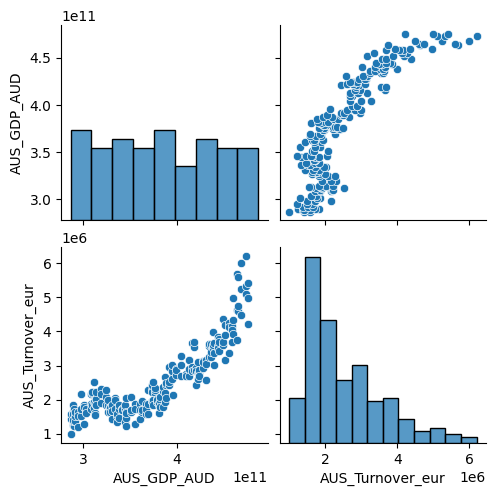

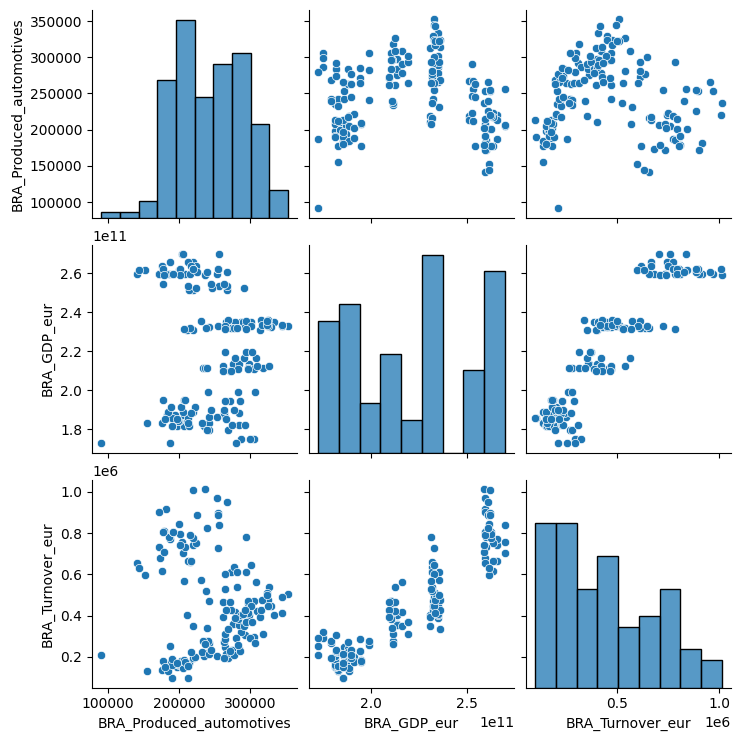

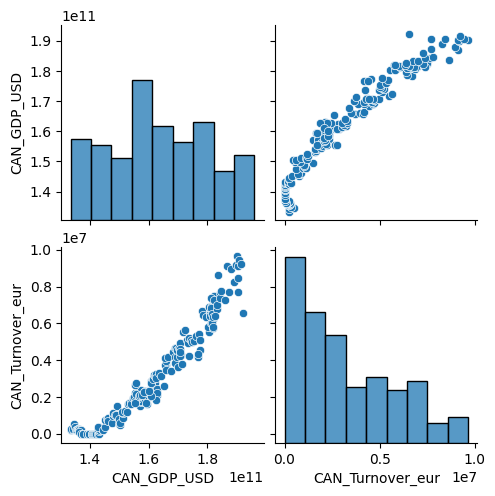

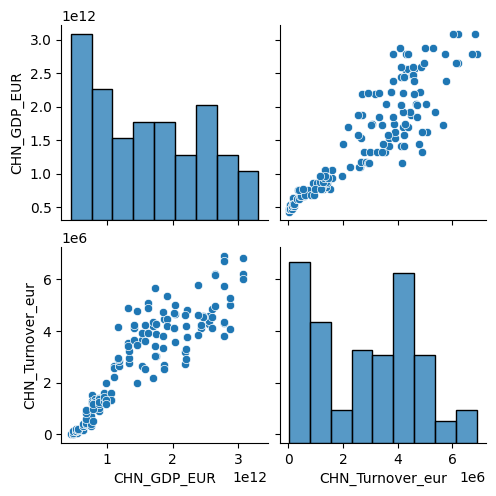

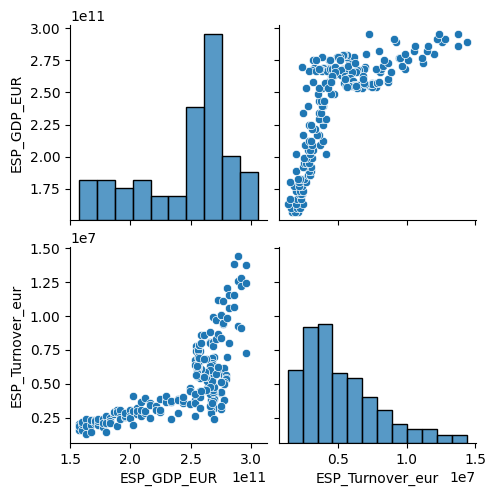

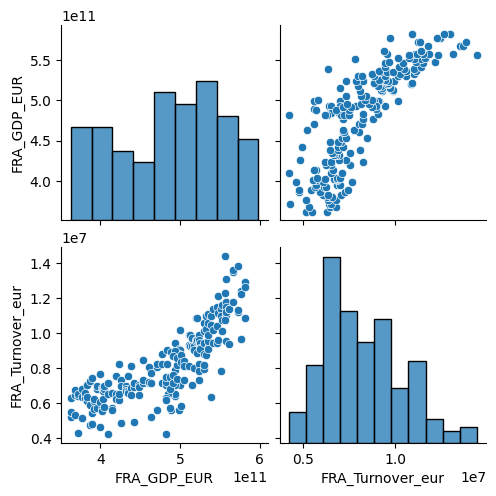

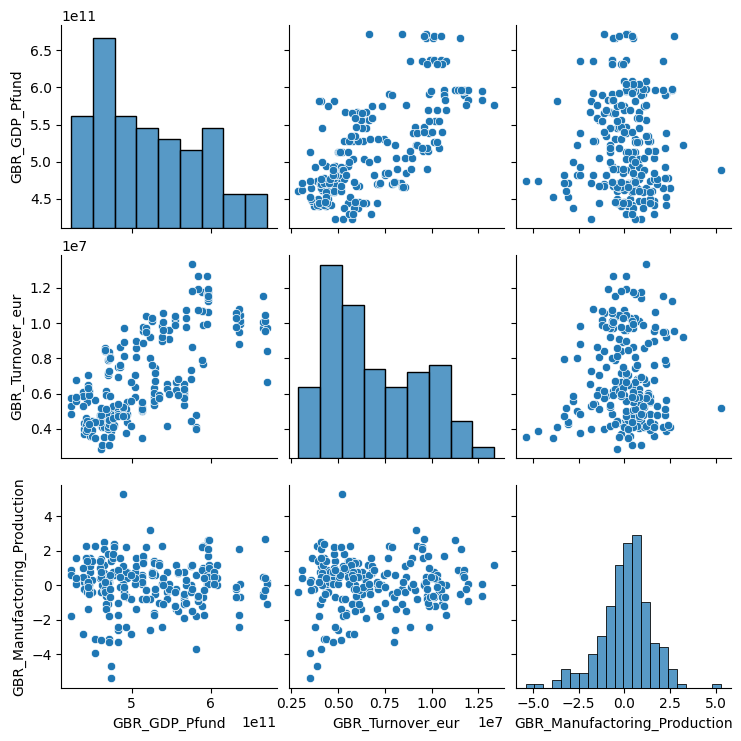

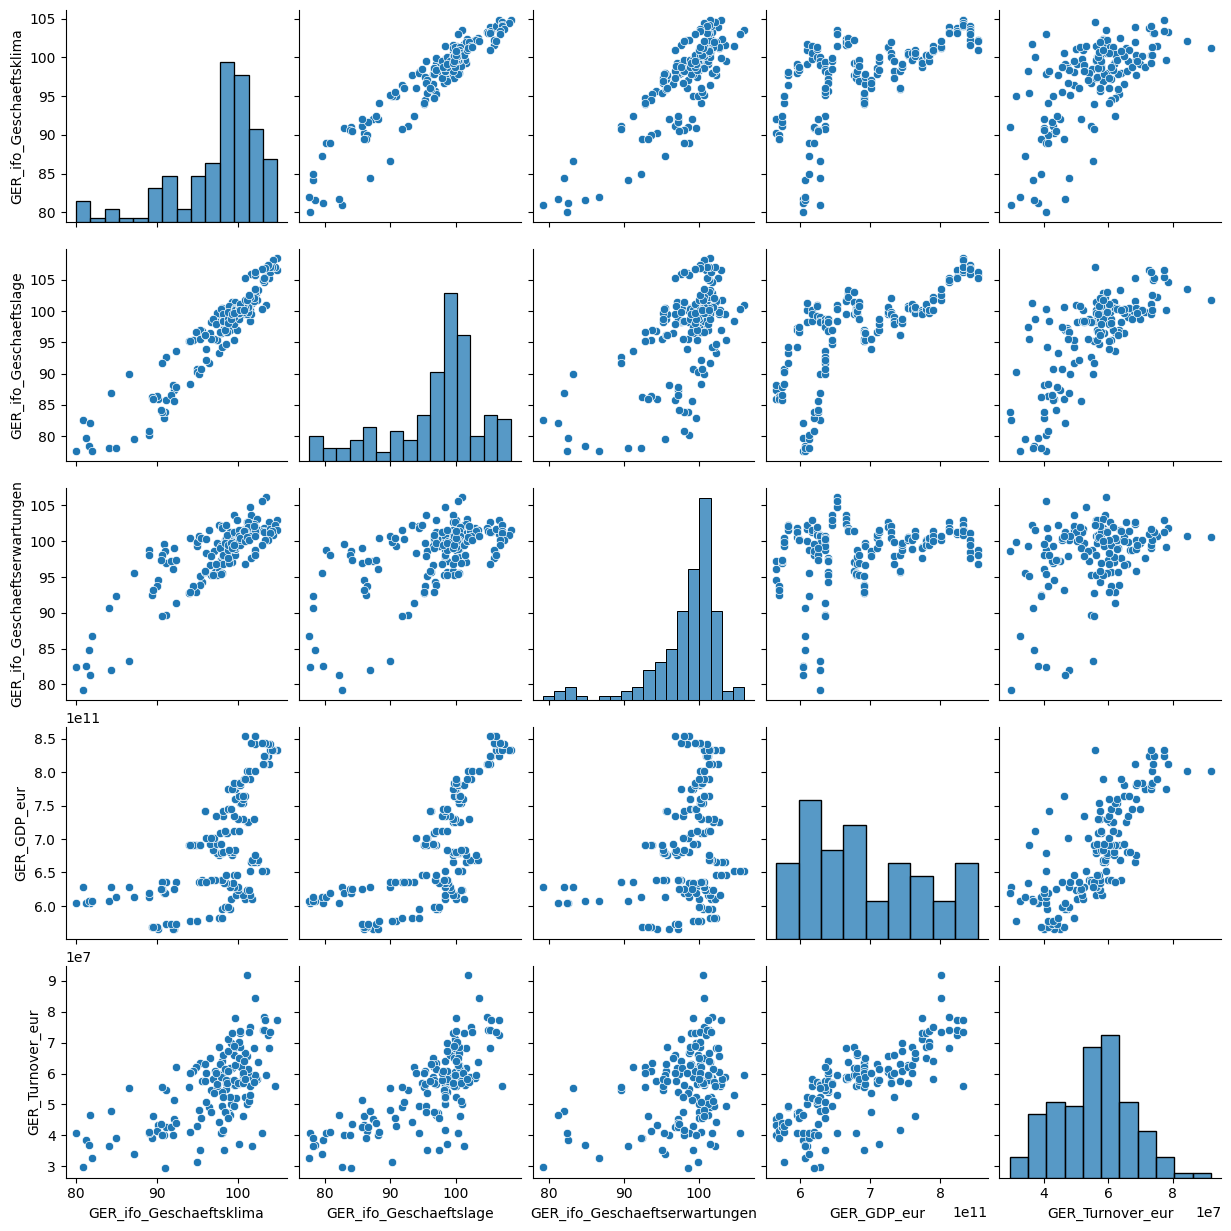

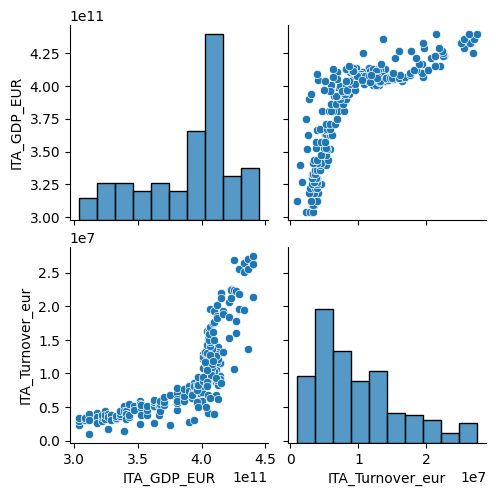

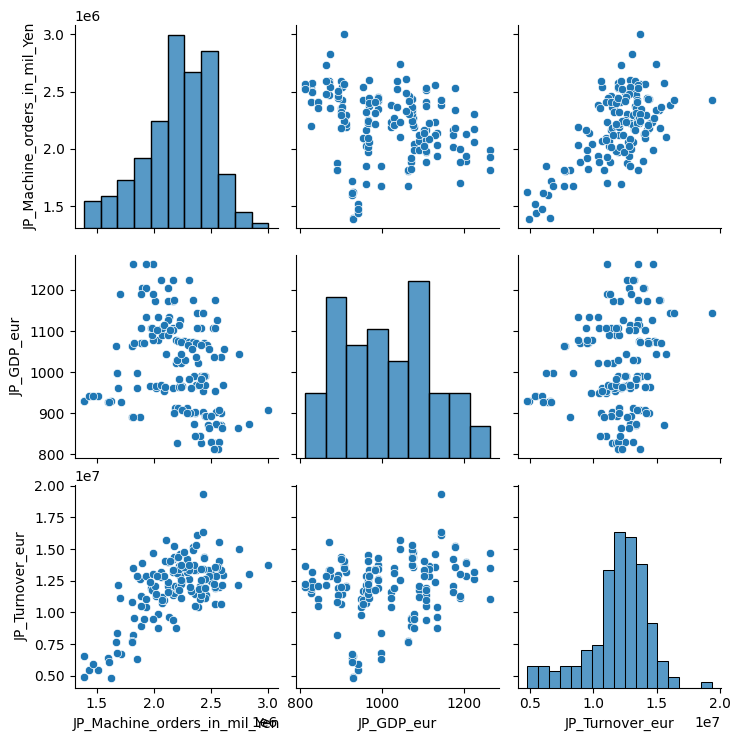

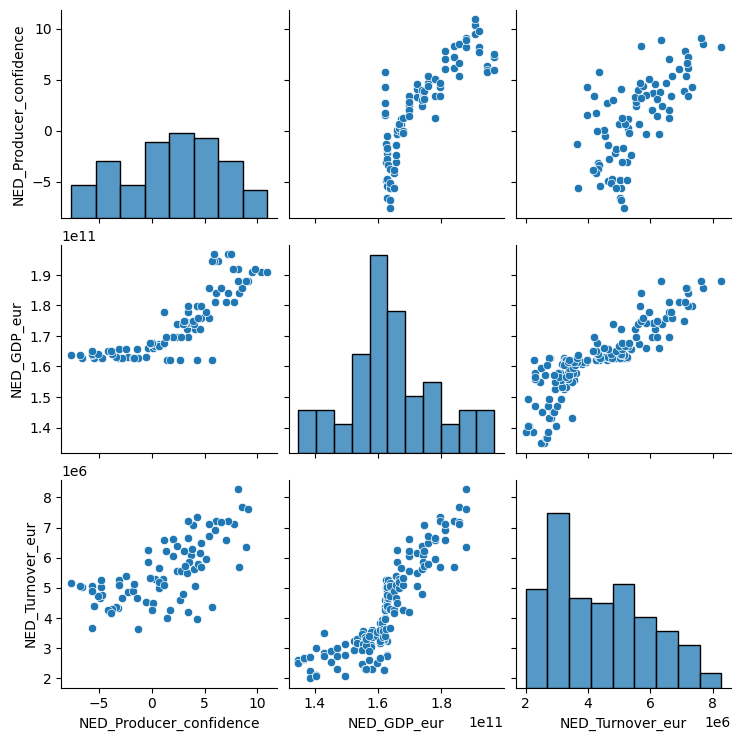

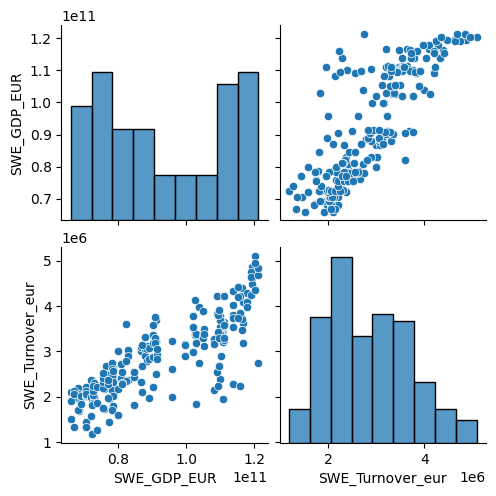

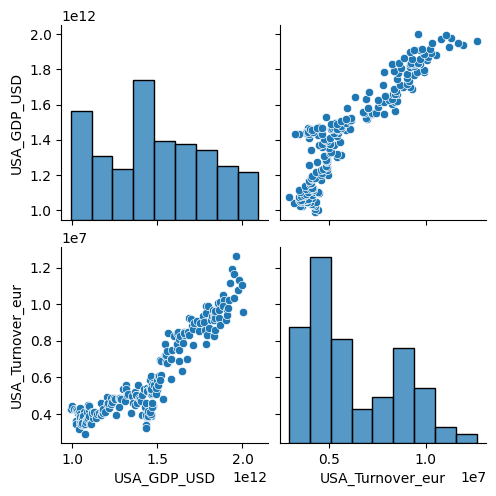

In [12]:
for country in country_list:
    sns.pairplot(countries[country])

### 1. AUSTRALIA:

##### EDA

In [13]:
aus.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Month             228 non-null    datetime64[ns]
 1   AUS_GDP_AUD       228 non-null    int64         
 2   AUS_Turnover_eur  216 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.5 KB


In [14]:
aus.corr()

,Month,AUS_GDP_AUD,AUS_Turnover_eur
Month,1.000000,0.999198,0.862235
AUS_GDP_AUD,0.999198,1.000000,0.864658
AUS_Turnover_eur,0.862235,0.864658,1.000000


In [15]:
aus_tmpdf = granger_test(aus)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=30.3242 , p=0.0000  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=30.7533 , p=0.0000  , df=1
likelihood ratio test: chi2=28.7434 , p=0.0000  , df=1
parameter F test:         F=30.3242 , p=0.0000  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=13.2845 , p=0.0000  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=27.2047 , p=0.0000  , df=2
likelihood ratio test: chi2=25.6094 , p=0.0000  , df=2
parameter F test:         F=13.2845 , p=0.0000  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.1676  , p=0.0005  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=19.1314 , p=0.0003  , df=3
likelihood ratio test: chi2=18.3204 , p=0.0004  , df=3
parameter F test:         F=6.1676  , p=0.0005  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=4.7142  , p=0.0012  

In [16]:
aus_train, aus_test = aus_tmpdf[aus_tmpdf.index.year<2017],aus_tmpdf[aus_tmpdf.index.year==2017]

In [17]:
for c in aus_train.columns:
    adfuller_test(aus_train[c])

ADF Statistic: 1.1767
p-value: 0.9958
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: 0.1134
p-value: 0.9670
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)


In [18]:
aus_tmpdf_diff = aus_train.diff().dropna()

In [19]:
for c in aus_tmpdf_diff.columns:
    adfuller_test(aus_tmpdf_diff[c])

ADF Statistic: -3.4105
p-value: 0.0106
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -3.9557
p-value: 0.0017
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)


Rejected Null Hypothesis, so stationary

In [20]:
aus_model = VAR(aus_tmpdf_diff)
x = aus_model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.14,68.18,3.932e+29,68.16
1,67.71,67.82,2.558e+29,67.76
2,67.34,67.52,1.757e+29,67.41
3,67.10,67.35*,1.381e+29,67.20
4,67.10,67.43,1.391e+29,67.24
5,67.06,67.46,1.329e+29,67.22
6,66.98,67.45,1.226e+29,67.17*
7,66.99,67.53,1.237e+29,67.21
8,67.02,67.64,1.279e+29,67.27
9,67.06,67.75,1.334e+29,67.34


Min Aic at p=16

In [21]:
aus_model_fitted = aus_model.fit(16)
lag_order = aus_model_fitted.k_ar
print(lag_order)

16


In [22]:
aus_forecast_input = aus_tmpdf_diff.values[-lag_order:]
aus_forecast_input

array([[ 9.41376088e+04,  0.00000000e+00],
       [ 2.14124107e+05,  2.55800000e+09],
       [ 2.99977813e+05,  0.00000000e+00],
       [-1.04474575e+06,  0.00000000e+00],
       [ 2.18369486e+05,  3.76800000e+09],
       [ 8.89595209e+05,  0.00000000e+00],
       [-1.20546349e+05,  0.00000000e+00],
       [-4.59712623e+05,  3.21600000e+09],
       [ 4.77276810e+05,  0.00000000e+00],
       [-1.03006820e+05,  0.00000000e+00],
       [-1.15608700e+05,  6.71000000e+08],
       [ 1.03066781e+06,  0.00000000e+00],
       [-6.18749670e+05,  0.00000000e+00],
       [ 2.84407502e+05,  4.68400000e+09],
       [ 1.04486319e+06,  0.00000000e+00],
       [-1.94207087e+06,  0.00000000e+00]])

In [23]:
nobs=24
fc = aus_model_fitted.forecast(y=aus_forecast_input, steps=24)
aus_df_forecast = pd.DataFrame(fc, index=aus['Month'].iloc[-24:], columns=aus_tmpdf.columns)
aus_df_forecast

,y,x
Month,,
2017-01-01,507889.547501,2.585782e+09
2017-02-01,620856.648451,-3.308050e+08
2017-03-01,-452427.797870,-5.722772e+08
2017-04-01,116976.930524,3.340111e+09
2017-05-01,-47214.269598,-6.595560e+08
2017-06-01,-272955.887083,3.017449e+08
2017-07-01,528853.196296,2.593742e+09
2017-08-01,99705.056911,-2.913688e+08
2017-09-01,-611038.090958,-2.756227e+08


In [24]:
def aus_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [25]:
aus_df_results = aus_invert_transformation(aus_train.iloc[-24:], aus_df_forecast)       

Text(0.5, 1.0, 'AUS Turnover Forecast 2018')

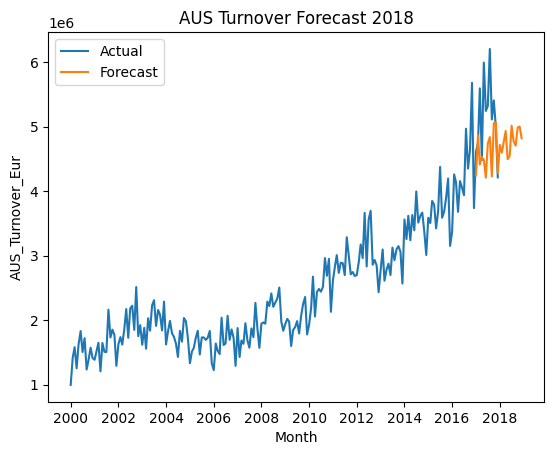

In [26]:
plt.plot(aus['Month'].iloc[:-12],aus['y'].iloc[:-12],label='Actual')
plt.plot(aus['Month'].iloc[-24:],aus_df_results.iloc[-24:]['y_forecast'],label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('AUS_Turnover_Eur')
plt.title('AUS Turnover Forecast 2018')

### 2. BRAZIL

In [27]:
bra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Month                     228 non-null    datetime64[ns]
 1   BRA_Produced_automotives  168 non-null    float64       
 2   BRA_GDP_eur               168 non-null    float64       
 3   BRA_Turnover_eur          156 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.2 KB


In [28]:
bra = bra.dropna(subset = ['BRA_GDP_eur'])

In [29]:
bra.corr()
# sns.pairplot(bra)

,Month,BRA_Produced_automotives,BRA_GDP_eur,BRA_Turnover_eur
Month,1.000000,0.030650,0.938064,0.947738
BRA_Produced_automotives,0.030650,1.000000,-0.053368,-0.032953
BRA_GDP_eur,0.938064,-0.053368,1.000000,0.914468
BRA_Turnover_eur,0.947738,-0.032953,0.914468,1.000000


In [30]:
bra_tmpdf = bra[['Month','BRA_Turnover_eur']].dropna()
bra_tmpdf.columns = ['ds','y']

In [31]:
bra_tmpdf = granger_test(bra[['Month','BRA_GDP_eur','BRA_Turnover_eur']])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=19.2708 , p=0.0000  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=19.6512 , p=0.0000  , df=1
likelihood ratio test: chi2=18.5017 , p=0.0000  , df=1
parameter F test:         F=19.2708 , p=0.0000  , df_denom=152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.1017  , p=0.0072  , df_denom=149, df_num=2
ssr based chi2 test:   chi2=10.5459 , p=0.0051  , df=2
likelihood ratio test: chi2=10.2005 , p=0.0061  , df=2
parameter F test:         F=5.1017  , p=0.0072  , df_denom=149, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.7360  , p=0.0458  , df_denom=146, df_num=3
ssr based chi2 test:   chi2=8.6015  , p=0.0351  , df=3
likelihood ratio test: chi2=8.3684  , p=0.0390  , df=3
parameter F test:         F=2.7360  , p=0.0458  , df_denom=146, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9704  , p=0.1022  

In [32]:
bra_train, bra_test = bra_tmpdf[bra_tmpdf.index.year<2017],bra_tmpdf[bra_tmpdf.index.year==2017]

In [33]:
for c in bra_train.columns:
    adfuller_test(bra_train[c])

ADF Statistic: 0.5985
p-value: 0.9876
Critical Values:
   1%: -3.4797
   5%: -2.8832
   10%: -2.5783
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -0.5243
p-value: 0.8872
Critical Values:
   1%: -3.4769
   5%: -2.8820
   10%: -2.5777
Result: Series is non-stationary (fail to reject null hypothesis)


In [34]:
bra_tmpdf_diff = bra_train.diff().dropna()

In [35]:
for c in bra_tmpdf_diff.columns:
    adfuller_test(bra_tmpdf_diff[c])

ADF Statistic: -6.2421
p-value: 0.0000
Critical Values:
   1%: -3.4797
   5%: -2.8832
   10%: -2.5783
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -12.0166
p-value: 0.0000
Critical Values:
   1%: -3.4773
   5%: -2.8821
   10%: -2.5777
Result: Series is stationary (reject null hypothesis)


Rejecting the null hypothesis, series is stationary

In [36]:
bra_model = VAR(bra_tmpdf_diff)
x = bra_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,66.82,66.87,1.047e+29,66.84
1,66.78,66.92,1.001e+29,66.83
2,66.57*,66.80*,8.136e+28*,66.66*
3,66.63,66.96,8.658e+28,66.76
4,66.66,67.08,8.934e+28,66.83
5,66.72,67.24,9.492e+28,66.93
6,66.77,67.38,9.956e+28,67.02
7,66.83,67.53,1.055e+29,67.11
8,66.83,67.63,1.064e+29,67.16
9,66.88,67.77,1.117e+29,67.24


Min AIC at p=2, but taking last 12 lags 

In [37]:
bra_model_fitted = bra_model.fit(12)
lag_order = bra_model_fitted.k_ar
print(lag_order)  

12


In [38]:
bra_forecast_input = bra_tmpdf_diff.values[-lag_order:]
bra_forecast_input

array([[-5.68169300e+04,  2.10551891e+09],
       [ 3.37609100e+04,  0.00000000e+00],
       [ 2.13527760e+05,  0.00000000e+00],
       [-1.09626120e+05, -1.72050639e+09],
       [ 7.46912600e+04,  0.00000000e+00],
       [-2.74426500e+04,  0.00000000e+00],
       [ 2.55693000e+04, -3.95663345e+08],
       [ 1.08447920e+05,  0.00000000e+00],
       [-1.50489600e+04,  0.00000000e+00],
       [-9.69452800e+04,  2.90311330e+09],
       [-2.86111500e+04,  0.00000000e+00],
       [ 1.91162100e+04,  0.00000000e+00]])

In [39]:
nobs=24
fc = bra_model_fitted.forecast(y=bra_forecast_input, steps=24)
bra_df_forecast = pd.DataFrame(fc, index=bra['Month'].iloc[-24:], columns=bra_tmpdf.columns)
bra_df_forecast

,y,x
Month,,
2017-01-01,-14802.165386,2.879522e+09
2017-02-01,29077.553086,3.655362e+09
2017-03-01,-10844.768213,2.547427e+09
2017-04-01,14222.673246,9.171172e+08
2017-05-01,31670.126500,-6.023921e+08
2017-06-01,860.845074,1.277063e+09
2017-07-01,15005.405029,2.248094e+09
2017-08-01,1561.188049,-5.630070e+08
2017-09-01,1633.034468,-1.658739e+09


In [40]:
def bra_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [41]:
bra_df_results = bra_invert_transformation(bra_train.iloc[-24:], bra_df_forecast)       

In [42]:
bra_actual_turnover = bra[bra['Month'].dt.year>=2017].iloc[:12]['BRA_Turnover_eur']
bra_pred_turnover = bra_df_results.iloc[:12]['y_forecast']

In [43]:
np.sqrt(mean_squared_error(bra_actual_turnover.values,bra_pred_turnover.values))

95463.0641104064

In [44]:
bra_mape = mean_absolute_percentage_error(bra_actual_turnover.values,bra_pred_turnover.values)*100
print(f'BRA MAPE:{bra_mape:.2f}%')

BRA MAPE:8.24%


Text(0.5, 1.0, 'BRA Turnover Forecast 2018')

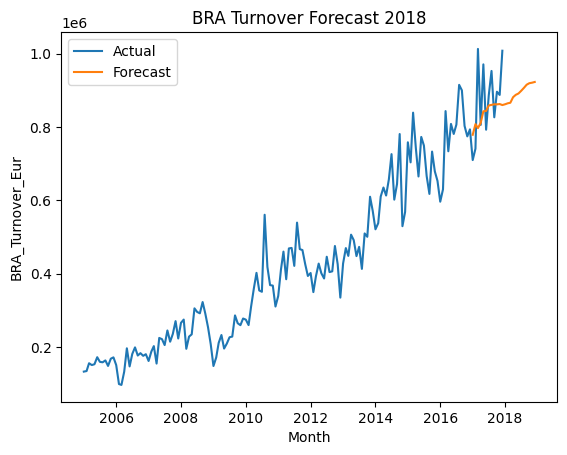

In [45]:
plt.plot(bra['Month'].iloc[:-12],bra['BRA_Turnover_eur'].iloc[:-12],label='Actual')
plt.plot(bra['Month'].iloc[-24:],bra_df_results.iloc[-24:]['y_forecast'],label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('BRA_Turnover_Eur')
plt.title('BRA Turnover Forecast 2018')

### 3. CANADA

In [46]:
can.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Month             228 non-null    datetime64[ns]
 1   CAN_GDP_USD       228 non-null    int64         
 2   CAN_Turnover_eur  216 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.5 KB


In [47]:
can.corr()

,Month,CAN_GDP_USD,CAN_Turnover_eur
Month,1.000000,0.986056,0.954979
CAN_GDP_USD,0.986056,1.000000,0.961720
CAN_Turnover_eur,0.954979,0.961720,1.000000


In [48]:
can_tmpdf = granger_test(can)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=31.4226 , p=0.0000  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=31.8672 , p=0.0000  , df=1
likelihood ratio test: chi2=29.7157 , p=0.0000  , df=1
parameter F test:         F=31.4226 , p=0.0000  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.0519  , p=0.0028  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=12.3934 , p=0.0020  , df=2
likelihood ratio test: chi2=12.0478 , p=0.0024  , df=2
parameter F test:         F=6.0519  , p=0.0028  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=3.6388  , p=0.0137  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=11.2873 , p=0.0103  , df=3
likelihood ratio test: chi2=10.9984 , p=0.0117  , df=3
parameter F test:         F=3.6388  , p=0.0137  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.0212  , p=0.0189  

In [49]:
can_train, can_test = can_tmpdf[can_tmpdf.index.year<2017],can_tmpdf[can_tmpdf.index.year==2017]

In [50]:
for c in can_train.columns:
    adfuller_test(can_train[c])

ADF Statistic: 1.3364
p-value: 0.9968
Critical Values:
   1%: -3.4638
   5%: -2.8763
   10%: -2.5746
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -0.3209
p-value: 0.9225
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
Result: Series is non-stationary (fail to reject null hypothesis)


In [51]:
can_tmpdf_diff = can_train.diff().dropna()

In [52]:
for c in can_tmpdf_diff.columns:
    adfuller_test(can_tmpdf_diff[c])

ADF Statistic: -9.8405
p-value: 0.0000
Critical Values:
   1%: -3.4638
   5%: -2.8763
   10%: -2.5746
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -5.8925
p-value: 0.0000
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
Result: Series is stationary (reject null hypothesis)


Rejecting Null hypothesis, stationary

In [53]:
can_model = VAR(can_tmpdf_diff)
x = can_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,66.69,66.72,9.156e+28,66.70
1,66.54,66.65*,7.901e+28,66.58
2,66.53,66.71,7.832e+28,66.60
3,66.49,66.74,7.511e+28,66.59
4,66.42*,66.74,7.038e+28*,66.55*
5,66.43,66.82,7.066e+28,66.59
6,66.45,66.91,7.219e+28,66.64
7,66.45,66.98,7.224e+28,66.67
8,66.47,67.08,7.392e+28,66.72
9,66.48,67.16,7.459e+28,66.75


Min AIC at 4, but taking atleast 12 lags

In [54]:
can_model_fitted = can_model.fit(12)


In [55]:
lag_order = can_model_fitted.k_ar
print(lag_order)  

12


In [56]:
forecast_input = can_tmpdf_diff.values[-lag_order:]
forecast_input

array([[ 9.81706031e+05,  1.20000000e+09],
       [-3.64860055e+05, -4.00000000e+08],
       [ 1.09820200e+06, -5.00000000e+08],
       [ 4.53712580e+03,  2.00000000e+08],
       [-1.11072376e+05, -1.10000000e+09],
       [-9.33251475e+04,  1.00000000e+09],
       [-2.68980426e+05,  9.00000000e+08],
       [ 1.59487492e+06,  5.00000000e+08],
       [-9.70608081e+05,  5.00000000e+08],
       [-2.93179153e+05,  0.00000000e+00],
       [ 4.14892765e+05,  5.00000000e+08],
       [-4.75283105e+05,  1.20000000e+09]])

In [57]:
nobs=24
fc = can_model_fitted.forecast(y=forecast_input, steps=24)
df_forecast = pd.DataFrame(fc, index=can['Month'].iloc[-24:], columns=can_tmpdf.columns)
df_forecast

,y,x
Month,,
2017-01-01,502836.046310,5.113785e+07
2017-02-01,234308.373964,5.231917e+08
2017-03-01,33183.703810,5.210927e+08
2017-04-01,-38700.772273,5.234492e+07
2017-05-01,-188584.657162,5.419541e+08
2017-06-01,22298.117007,2.976702e+08
2017-07-01,407644.170904,-7.270527e+07
2017-08-01,-69149.863963,3.554534e+08
2017-09-01,-27407.501370,3.481504e+08


In [58]:
def invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [59]:
df_results = invert_transformation(can_train.iloc[-24:], df_forecast)       

In [60]:
actual_turnover = can[can['Month'].dt.year>=2017].iloc[:12]['y']
pred_turnover = df_results.iloc[:12]['y_forecast']

In [61]:
np.sqrt(mean_squared_error(actual_turnover.values,pred_turnover.values))

1061927.9854812573

In [62]:
can_mape = mean_absolute_percentage_error(actual_turnover.values,pred_turnover.values)*100
print(f'CAN MAPE:{can_mape:.2f}%')

CAN MAPE:11.13%


Text(0.5, 1.0, 'CAN Turnover Forecast 2018')

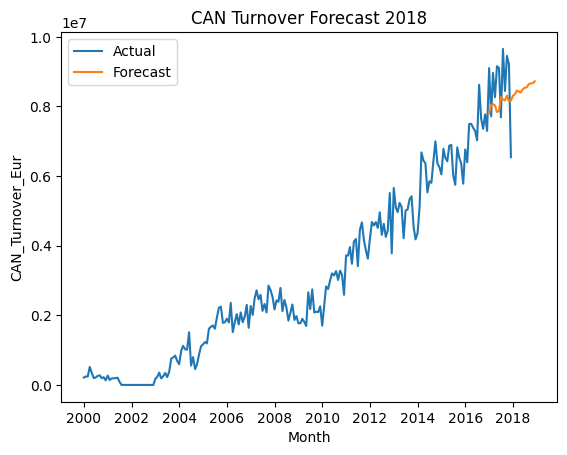

In [63]:
plt.plot(can.iloc[:-12]['Month'],can['y'].iloc[:-12], label='Actual')
plt.plot(can.iloc[-24:]['Month'],df_results['y_forecast'], label='Forecast')
plt.legend()
plt.xlabel('Month')
plt.ylabel('CAN_Turnover_Eur')
plt.title('CAN Turnover Forecast 2018')

### 4. CHINA

In [64]:
chn = chn.dropna(subset='CHN_GDP_EUR')

In [65]:
chn_tmpdf = granger_test(chn)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=18.1425 , p=0.0000  , df_denom=147, df_num=1
ssr based chi2 test:   chi2=18.5127 , p=0.0000  , df=1
likelihood ratio test: chi2=17.4564 , p=0.0000  , df=1
parameter F test:         F=18.1425 , p=0.0000  , df_denom=147, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.4799  , p=0.0008  , df_denom=144, df_num=2
ssr based chi2 test:   chi2=15.4792 , p=0.0004  , df=2
likelihood ratio test: chi2=14.7268 , p=0.0006  , df=2
parameter F test:         F=7.4799  , p=0.0008  , df_denom=144, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=5.1881  , p=0.0020  , df_denom=141, df_num=3
ssr based chi2 test:   chi2=16.3371 , p=0.0010  , df=3
likelihood ratio test: chi2=15.4967 , p=0.0014  , df=3
parameter F test:         F=5.1881  , p=0.0020  , df_denom=141, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.0274  , p=0.0000  

In [66]:
chn_train, chn_test = chn_tmpdf[chn_tmpdf.index.year<2017],chn_tmpdf[chn_tmpdf.index.year==2017]

In [67]:
for c in chn_train.columns:
    adfuller_test(chn_train[c])

ADF Statistic: -0.8437
p-value: 0.8060
Critical Values:
   1%: -3.4813
   5%: -2.8839
   10%: -2.5787
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -0.0415
p-value: 0.9550
Critical Values:
   1%: -3.4833
   5%: -2.8848
   10%: -2.5792
Result: Series is non-stationary (fail to reject null hypothesis)


In [68]:
chn_train_diff = chn_train.diff().dropna()

In [69]:
for c in chn_train_diff.columns:
    adfuller_test(chn_train_diff[c])

ADF Statistic: -7.1774
p-value: 0.0000
Critical Values:
   1%: -3.4813
   5%: -2.8839
   10%: -2.5787
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -2.5598
p-value: 0.1016
Critical Values:
   1%: -3.4833
   5%: -2.8848
   10%: -2.5792
Result: Series is non-stationary (fail to reject null hypothesis)


rejecting the null hypothesis, turnover series in stationary

In [70]:
chn_model = VAR(chn_train_diff)
x = chn_model.select_order(maxlags=12)
x.summary()

,AIC,BIC,FPE,HQIC
0,77.58,77.63,4.944e+33,77.60
1,77.56,77.70,4.829e+33,77.61
2,77.26,77.49,3.588e+33,77.35
3,77.09,77.40*,3.005e+33,77.21
4,77.06,77.46,2.930e+33,77.22
5,77.08,77.57,2.988e+33,77.28
6,77.00,77.58,2.760e+33,77.24
7,76.89,77.57,2.480e+33,77.17
8,76.92,77.68,2.544e+33,77.23
9,76.67,77.53,1.997e+33,77.02


Min AIC at 12, so p=12

In [71]:
lag_order=12
chn_model_fitted = chn_model.fit(lag_order)

In [72]:
chn_forecast_input = chn_train_diff.values[-lag_order:]
chn_forecast_input

array([[-1.04481563e+06, -5.79390847e+11],
       [-3.93895891e+05,  0.00000000e+00],
       [ 1.27702565e+06,  0.00000000e+00],
       [ 3.19076175e+05,  2.58334801e+11],
       [ 4.53873288e+04,  0.00000000e+00],
       [-1.71201433e+04,  0.00000000e+00],
       [-4.18723944e+05,  1.30527057e+11],
       [ 7.01593405e+05,  0.00000000e+00],
       [-2.84097260e+05,  0.00000000e+00],
       [-4.84559025e+05,  2.80089310e+11],
       [ 9.34281333e+05,  0.00000000e+00],
       [ 2.92431971e+05,  0.00000000e+00]])

In [73]:
nobs=24
fc = chn_model_fitted.forecast(y=chn_forecast_input, steps=24)
chn_df_forecast = pd.DataFrame(fc, index=chn['Month'].iloc[-24:], columns=chn_tmpdf.columns)
chn_df_forecast

,y,x
Month,,
2017-01-01,-1.705606e+06,-5.655725e+11
2017-02-01,-3.894528e+05,-1.219576e+10
2017-03-01,1.693169e+06,2.369230e+10
2017-04-01,9.397796e+05,2.573893e+11
2017-05-01,-4.869443e+05,-1.343740e+09
2017-06-01,-9.452578e+05,-7.385531e+09
2017-07-01,8.864051e+05,1.005670e+11
2017-08-01,3.194336e+05,1.852581e+10
2017-09-01,-8.289464e+05,1.848814e+10


In [74]:
def chn_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [75]:
chn_df_results = chn_invert_transformation(chn_train.iloc[-24:], chn_df_forecast)       

In [76]:
chn_actual_turnover = chn[chn['Month'].dt.year==2017]['y']
chn_pred_turnover = chn_df_results.iloc[:12]['y_forecast']

In [77]:
np.sqrt(mean_squared_error(chn_actual_turnover,chn_pred_turnover))

1210140.4420269474

In [78]:
chn_mape = mean_absolute_percentage_error(chn_actual_turnover.values,chn_pred_turnover.values)*100
print(f'CHN MAPE:{chn_mape:.2f}%')

CHN MAPE:18.49%


Text(0.5, 1.0, 'CHN Turnover Forecast 2018')

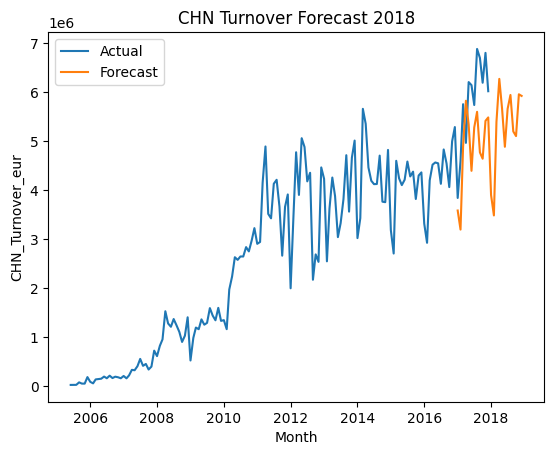

In [79]:
plt.plot(chn.iloc[:-12]['Month'],chn['y'].iloc[:-12], label = 'Actual')
plt.plot(chn.iloc[-24:]['Month'],chn_df_results['y_forecast'],label = 'Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('CHN_Turnover_eur')
plt.title('CHN Turnover Forecast 2018')

### 5. ESP

<Axes: xlabel='Month', ylabel='ESP_Turnover_eur'>

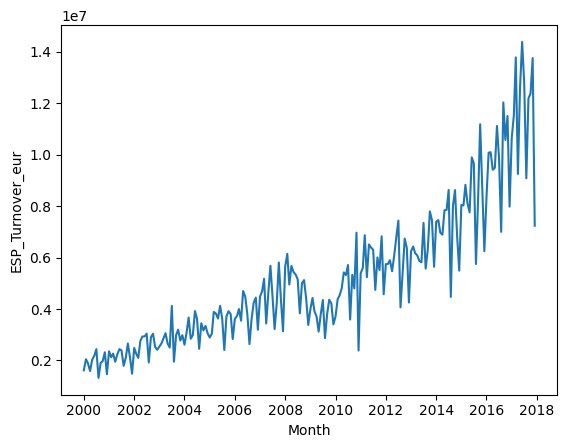

In [80]:
sns.lineplot(data=esp,x='Month',y='ESP_Turnover_eur')

<Axes: xlabel='Month', ylabel='ESP_GDP_EUR'>

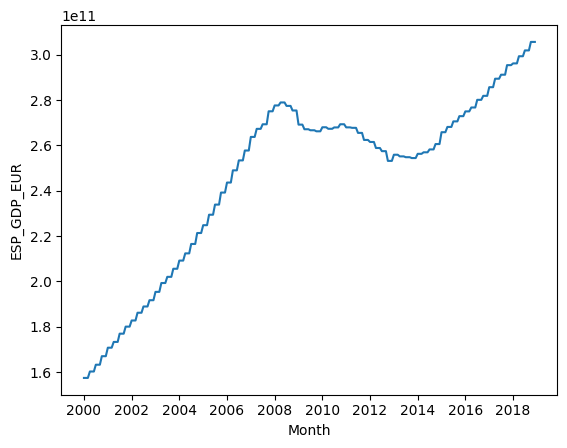

In [81]:
sns.lineplot(data=esp,x='Month',y='ESP_GDP_EUR')

In [82]:
esp_tmpdf = granger_test(esp)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=14.5313 , p=0.0002  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=14.7370 , p=0.0001  , df=1
likelihood ratio test: chi2=14.2539 , p=0.0002  , df=1
parameter F test:         F=14.5313 , p=0.0002  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=3.6189  , p=0.0285  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=7.4110  , p=0.0246  , df=2
likelihood ratio test: chi2=7.2856  , p=0.0262  , df=2
parameter F test:         F=3.6189  , p=0.0285  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=1.0957  , p=0.3520  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=3.3987  , p=0.3341  , df=3
likelihood ratio test: chi2=3.3718  , p=0.3378  , df=3
parameter F test:         F=1.0957  , p=0.3520  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9703  , p=0.1004  

In [83]:
esp_train, esp_test = esp_tmpdf[esp_tmpdf.index.year<2017],esp_tmpdf[esp_tmpdf.index.year==2017]

In [84]:
for c in esp_train.columns:
    adfuller_test(esp_train[c])

ADF Statistic: 1.3868
p-value: 0.9971
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -1.9156
p-value: 0.3248
Critical Values:
   1%: -3.4640
   5%: -2.8763
   10%: -2.5747
Result: Series is non-stationary (fail to reject null hypothesis)


In [85]:
esp_tmpdf_diff = esp_train.diff().dropna()

In [86]:
for c in esp_tmpdf_diff.columns:
    adfuller_test(esp_tmpdf_diff[c])

ADF Statistic: -2.8953
p-value: 0.0459
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -1.9597
p-value: 0.3045
Critical Values:
   1%: -3.4640
   5%: -2.8763
   10%: -2.5747
Result: Series is non-stationary (fail to reject null hypothesis)


rejecting the null hypthesis, turnover series is stationary

In [87]:
esp_model = VAR(esp_tmpdf_diff)
x = esp_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,70.77,70.81,5.444e+30,70.79
1,70.61,70.72,4.627e+30,70.65
2,70.39,70.57,3.724e+30,70.46
3,69.00,69.25*,9.252e+29,69.10
4,69.03,69.35,9.503e+29,69.16
5,69.06,69.45,9.841e+29,69.22
6,68.92,69.38,8.526e+29,69.11
7,68.84,69.37,7.864e+29,69.05*
8,68.87,69.48,8.167e+29,69.12
9,68.87,69.54,8.114e+29,69.14


Min AIC at 15, so p=15

In [88]:
esp_model_fitted = esp_model.fit(15)
lag_order = esp_model_fitted.k_ar
print(lag_order) 

15


In [89]:
esp_forecast_input = esp_tmpdf_diff.values[-lag_order:]
esp_forecast_input

array([[ 2.91991057e+06,  2.30000000e+09],
       [-2.50866325e+06,  0.00000000e+00],
       [-2.42764003e+06,  0.00000000e+00],
       [ 2.10449963e+06,  2.11000000e+09],
       [ 1.72911861e+06,  0.00000000e+00],
       [ 1.62970080e+04,  0.00000000e+00],
       [-6.83499844e+05,  1.72000000e+09],
       [ 7.54087656e+04,  0.00000000e+00],
       [ 1.62913032e+06,  0.00000000e+00],
       [-1.25682848e+06,  3.38000000e+09],
       [-2.86108340e+06,  0.00000000e+00],
       [ 5.03128156e+06,  0.00000000e+00],
       [-1.45778912e+06,  1.76000000e+09],
       [ 9.32095483e+05,  0.00000000e+00],
       [-3.52525557e+06,  0.00000000e+00]])

In [90]:
nobs=24
fc = esp_model_fitted.forecast(y=esp_forecast_input, steps=24)
esp_df_forecast = pd.DataFrame(fc, index=esp['Month'].iloc[-24:], columns=esp_tmpdf.columns)
esp_df_forecast

,y,x
Month,,
2017-01-01,2.618772e+06,2.736041e+09
2017-02-01,1.130837e+05,-6.562374e+08
2017-03-01,1.206466e+06,-9.204720e+08
2017-04-01,-1.968426e+06,2.261837e+09
2017-05-01,1.155075e+06,-3.964767e+08
2017-06-01,3.633763e+05,-6.018920e+07
2017-07-01,-8.669520e+05,1.948598e+09
2017-08-01,-1.963796e+06,-9.785842e+08
2017-09-01,3.383351e+06,-2.832318e+07


In [91]:
def esp_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [92]:
esp_df_results = esp_invert_transformation(esp_train.iloc[-24:], esp_df_forecast)       

In [93]:
esp_actual_turnover = esp[esp['Month'].dt.year>=2017].iloc[:12]['y']
esp_pred_turnover = esp_df_results.iloc[:12]['y_forecast']

In [94]:
np.sqrt(mean_squared_error(esp_actual_turnover.values,esp_pred_turnover.values))

1557385.8719249207

In [95]:
esp_mape = mean_absolute_percentage_error(esp_actual_turnover.values,esp_pred_turnover.values)*100
print(f'ESP MAPE:{esp_mape:.2f}%')

ESP MAPE:11.02%


Text(0.5, 1.0, 'ESP Turnover Forecast 2018')

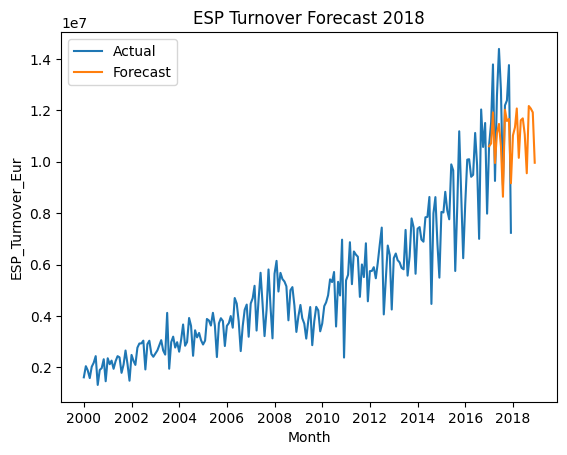

In [96]:
plt.plot(esp['Month'].iloc[:-12],esp['y'].iloc[:-12], label='Actual')
plt.plot(esp['Month'].iloc[-24:],esp_df_results.iloc[-24:]['y_forecast'], label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('ESP_Turnover_Eur')
plt.title('ESP Turnover Forecast 2018')

### 6. FRANCE

In [97]:
fra.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Month             228 non-null    datetime64[ns]
 1   FRA_GDP_EUR       228 non-null    int64         
 2   FRA_Turnover_eur  216 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.5 KB


In [98]:
fra.corr()

,Month,FRA_GDP_EUR,FRA_Turnover_eur
Month,1.000000,0.988254,0.830637
FRA_GDP_EUR,0.988254,1.000000,0.815203
FRA_Turnover_eur,0.830637,0.815203,1.000000


In [99]:
fra_tmpdf = granger_test(fra)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=86.1697 , p=0.0000  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=87.3891 , p=0.0000  , df=1
likelihood ratio test: chi2=73.3314 , p=0.0000  , df=1
parameter F test:         F=86.1697 , p=0.0000  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=35.0923 , p=0.0000  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=71.8638 , p=0.0000  , df=2
likelihood ratio test: chi2=61.9614 , p=0.0000  , df=2
parameter F test:         F=35.0923 , p=0.0000  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=8.1873  , p=0.0000  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=25.3965 , p=0.0000  , df=3
likelihood ratio test: chi2=23.9930 , p=0.0000  , df=3
parameter F test:         F=8.1873  , p=0.0000  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=9.9981  , p=0.0000  

In [100]:
fra_tmpdf.head()

,y,x
Month,,
2000-01-01,5.201266e+06,3.625600e+11
2000-02-01,5.479398e+06,3.625600e+11
2000-03-01,6.326710e+06,3.625600e+11
2000-04-01,5.335928e+06,3.676100e+11
2000-05-01,6.464082e+06,3.676100e+11


In [101]:
fra_train, fra_test = fra_tmpdf[fra_tmpdf.index.year<2017],fra_tmpdf[fra_tmpdf.index.year==2017]

In [102]:
for c in fra_train.columns:
    adfuller_test(fra_train[c])

ADF Statistic: -0.4679
p-value: 0.8981
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -1.1060
p-value: 0.7127
Critical Values:
   1%: -3.4645
   5%: -2.8766
   10%: -2.5748
Result: Series is non-stationary (fail to reject null hypothesis)


In [103]:
fra_tmpdf_diff = fra_train.diff().dropna()

In [104]:
for c in fra_tmpdf_diff.columns:
    adfuller_test(fra_tmpdf_diff[c])

ADF Statistic: -3.4305
p-value: 0.0100
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -3.6189
p-value: 0.0054
Critical Values:
   1%: -3.4645
   5%: -2.8766
   10%: -2.5748
Result: Series is stationary (reject null hypothesis)


rejecting the null hypothesis, stationarity

In [105]:
fra_model = VAR(fra_tmpdf_diff)
x = fra_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,71.44,71.48,1.065e+31,71.46
1,71.05,71.16,7.195e+30,71.09
2,70.63,70.81,4.731e+30,70.70
3,69.82,70.07,2.106e+30,69.92
4,69.83,70.15,2.121e+30,69.96
5,69.82,70.21,2.095e+30,69.98
6,69.80,70.26,2.058e+30,69.99
7,69.68,70.22,1.831e+30,69.90
8,69.64,70.25,1.760e+30,69.89
9,69.59,70.27,1.677e+30,69.87


Min AIC at 13, so p=13

In [106]:
fra_model_fitted = fra_model.fit(13)
lag_order = fra_model_fitted.k_ar
print(lag_order)  

13


In [107]:
fra_forecast_input = fra_tmpdf_diff.values[-lag_order:]
fra_forecast_input

array([[-6.39658630e+05,  0.00000000e+00],
       [ 9.31044842e+05,  4.73000000e+09],
       [ 7.45972266e+05,  0.00000000e+00],
       [ 1.31041500e+06,  0.00000000e+00],
       [-8.34307422e+05, -1.65000000e+09],
       [-1.51870943e+06,  0.00000000e+00],
       [ 3.62999450e+06,  0.00000000e+00],
       [-2.90768184e+06,  1.59000000e+09],
       [-1.93616225e+06,  0.00000000e+00],
       [ 1.65051593e+06,  0.00000000e+00],
       [ 1.64483150e+05,  3.31000000e+09],
       [ 1.44767740e+04,  0.00000000e+00],
       [-1.95738837e+06,  0.00000000e+00]])

In [108]:
nobs=24
fc = fra_model_fitted.forecast(y=fra_forecast_input, steps=24)
fra_df_forecast = pd.DataFrame(fc, index=fra['Month'].iloc[-24:], columns=esp_tmpdf.columns)
fra_df_forecast

,y,x
Month,,
2017-01-01,1.860349e+06,3.477673e+09
2017-02-01,1.256674e+06,5.698210e+08
2017-03-01,8.374287e+05,-3.710806e+08
2017-04-01,-1.413993e+06,3.556451e+09
2017-05-01,-8.376064e+05,1.818201e+08
2017-06-01,2.924340e+06,-9.697622e+07
2017-07-01,-1.727420e+06,3.623471e+09
2017-08-01,-2.008486e+06,-4.208215e+08
2017-09-01,1.406023e+06,4.912881e+08


In [109]:
def fra_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [110]:
fra_df_results = fra_invert_transformation(fra_train.iloc[-24:], fra_df_forecast)       

In [111]:
fra_actual_turnover = fra[fra['Month'].dt.year>=2017].iloc[:12]['y']
fra_pred_turnover = fra_df_results.iloc[:12]['y_forecast']

In [112]:
np.sqrt(mean_squared_error(fra_actual_turnover.values,fra_pred_turnover.values))

789627.0582105621

In [113]:
fra_mape = mean_absolute_percentage_error(fra_actual_turnover.values,fra_pred_turnover.values)*100
print(f'FRA MAPE:{fra_mape:.2f}%')

FRA MAPE:4.63%


Text(0.5, 1.0, 'FRA Turnover Forecast 2018')

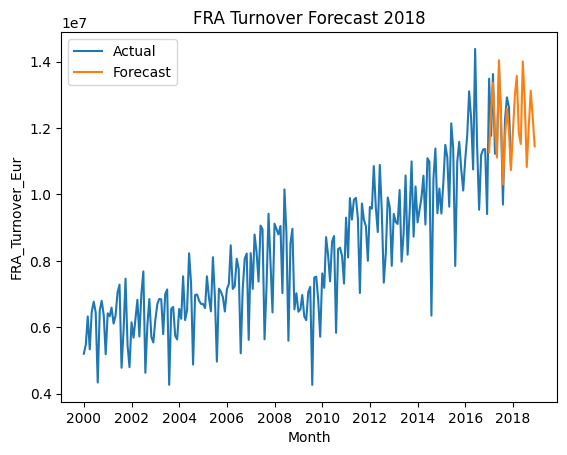

In [114]:
plt.plot(fra.iloc[:-12]['Month'],fra['y'].iloc[:-12], label='Actual')
plt.plot(fra.iloc[-24:]['Month'],fra_df_results.iloc[-24:]['y_forecast'],label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('FRA_Turnover_Eur')
plt.title('FRA Turnover Forecast 2018')

### 7. GBR

In [115]:
gbr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Month                         228 non-null    datetime64[ns]
 1   GBR_GDP_Pfund                 228 non-null    int64         
 2   GBR_Turnover_eur              216 non-null    float64       
 3   GBR_Manufactoring_Production  228 non-null    float64       
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 7.2 KB


In [116]:
gbr.corr()

,Month,GBR_GDP_Pfund,GBR_Turnover_eur,GBR_Manufactoring_Production
Month,1.000000,0.696751,0.918029,0.013970
GBR_GDP_Pfund,0.696751,1.000000,0.669276,0.006645
GBR_Turnover_eur,0.918029,0.669276,1.000000,0.053561
GBR_Manufactoring_Production,0.013970,0.006645,0.053561,1.000000


In [117]:
gbr_tmpdf = granger_test(gbr[['Month','GBR_GDP_Pfund','GBR_Turnover_eur']])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=8.4521  , p=0.0040  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=8.5717  , p=0.0034  , df=1
likelihood ratio test: chi2=8.4053  , p=0.0037  , df=1
parameter F test:         F=8.4521  , p=0.0040  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=1.2314  , p=0.2940  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=2.5217  , p=0.2834  , df=2
likelihood ratio test: chi2=2.5070  , p=0.2855  , df=2
parameter F test:         F=1.2314  , p=0.2940  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.2870  , p=0.8348  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=0.8903  , p=0.8278  , df=3
likelihood ratio test: chi2=0.8884  , p=0.8282  , df=3
parameter F test:         F=0.2870  , p=0.8348  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=0.0457  , p=0.9960  

In [118]:
gbr_train, gbr_test = gbr_tmpdf[gbr_tmpdf.index.year<2017],gbr_tmpdf[gbr_tmpdf.index.year==2017]

In [119]:
for c in gbr_train.columns:
    adfuller_test(gbr_train[c])

ADF Statistic: -0.0446
p-value: 0.9547
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -1.7103
p-value: 0.4258
Critical Values:
   1%: -3.4645
   5%: -2.8766
   10%: -2.5748
Result: Series is non-stationary (fail to reject null hypothesis)


In [120]:
gbr_tmpdf_diff = gbr_train.diff().dropna()

In [121]:
for c in gbr_tmpdf_diff.columns:
    adfuller_test(gbr_tmpdf_diff[c])

ADF Statistic: -3.2167
p-value: 0.0190
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -5.9753
p-value: 0.0000
Critical Values:
   1%: -3.4640
   5%: -2.8763
   10%: -2.5747
Result: Series is stationary (reject null hypothesis)


Rejecting the null hypothesis, stationary

1st differencing

In [122]:
gbr_model = VAR(gbr_tmpdf_diff)
x = gbr_model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,74.09,74.12,1.499e+32,74.10
1,73.84,73.95,1.171e+32,73.88
2,73.74,73.92,1.061e+32,73.82
3,73.56,73.81*,8.820e+31,73.66
4,73.58,73.91,9.063e+31,73.72
5,73.61,74.01,9.336e+31,73.78
6,73.62,74.10,9.416e+31,73.81
7,73.62,74.16,9.379e+31,73.84
8,73.66,74.28,9.770e+31,73.91
9,73.66,74.36,9.825e+31,73.94


In [123]:
gbr_model_fitted = gbr_model.fit(15)
lag_order = gbr_model_fitted.k_ar
print(lag_order)  

15


In [124]:
gbr_forecast_input = gbr_tmpdf_diff.values[-lag_order:]
gbr_forecast_input

array([[-3.46837544e+05,  4.51000000e+09],
       [-1.26556061e+06,  0.00000000e+00],
       [-1.78096841e+06,  0.00000000e+00],
       [ 2.91105025e+06, -2.37000000e+09],
       [ 5.34739614e+05,  0.00000000e+00],
       [ 3.80302140e+05,  0.00000000e+00],
       [-9.94733938e+05, -3.33900000e+10],
       [-6.54267871e+05,  0.00000000e+00],
       [ 1.95426368e+06,  0.00000000e+00],
       [-1.01841226e+06, -3.85000000e+09],
       [ 7.90841077e+05,  0.00000000e+00],
       [-2.85197789e+05,  0.00000000e+00],
       [ 3.92847176e+05, -4.27700000e+10],
       [ 1.06857653e+06,  0.00000000e+00],
       [-3.85873127e+06,  0.00000000e+00]])

In [125]:
nobs=24
fc = gbr_model_fitted.forecast(y=gbr_forecast_input, steps=24)
gbr_df_forecast = pd.DataFrame(fc, index=gbr['Month'].iloc[-24:], columns=gbr_tmpdf.columns)
gbr_df_forecast

,y,x
Month,,
2017-01-01,3.039344e+06,-1.035602e+10
2017-02-01,6.201429e+05,8.926539e+09
2017-03-01,-1.805125e+05,8.346481e+09
2017-04-01,-7.023942e+05,-1.062495e+10
2017-05-01,-6.935323e+05,4.617728e+09
2017-06-01,1.628165e+06,1.153748e+09
2017-07-01,-6.698677e+05,3.545461e+09
2017-08-01,7.102867e+04,6.339066e+09
2017-09-01,5.924506e+03,-1.360774e+09


In [126]:
def gbr_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [127]:
gbr_df_results = gbr_invert_transformation(gbr_train.iloc[-24:], gbr_df_forecast)       

In [128]:
gbr_actual_turnover = gbr[gbr['Month'].dt.year>=2017].iloc[:12]['GBR_Turnover_eur']
gbr_pred_turnover = gbr_df_results.iloc[:12]['y_forecast']

In [129]:
np.sqrt(mean_squared_error(gbr_actual_turnover.values,gbr_pred_turnover.values))

1053413.0200608708

In [130]:
gbr_mape = mean_absolute_percentage_error(gbr_actual_turnover.values,gbr_pred_turnover.values)*100
print(f'GBR MAPE:{gbr_mape:.2f}%')

GBR MAPE:8.19%


Text(0.5, 1.0, 'GBR Turnover Forecast 2018')

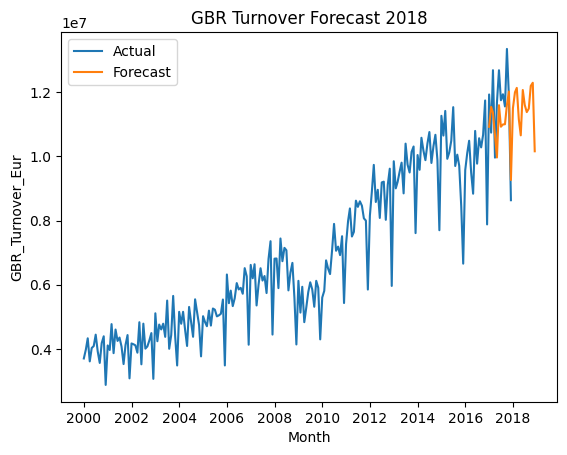

In [131]:
plt.plot(gbr.iloc[:-12]['Month'],gbr['GBR_Turnover_eur'].iloc[:-12], label="Actual")
plt.plot(gbr.iloc[-24:]['Month'],gbr_df_results.iloc[-24:]['y_forecast'], label="Forecast")
plt.xlabel('Month')
plt.legend()
plt.ylabel('GBR_Turnover_Eur')
plt.title('GBR Turnover Forecast 2018')

### 8. GERMANY

In [132]:
ger.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 6 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Month                          228 non-null    datetime64[ns]
 1   GER_ifo_Geschaeftsklima        168 non-null    float64       
 2   GER_ifo_Geschaeftslage         168 non-null    float64       
 3   GER_ifo_Geschaeftserwartungen  168 non-null    float64       
 4   GER_GDP_eur                    168 non-null    float64       
 5   GER_Turnover_eur               156 non-null    float64       
dtypes: datetime64[ns](1), float64(5)
memory usage: 10.8 KB


In [133]:
ger = ger.dropna(subset='GER_GDP_eur')

In [134]:
ger.head()

,Month,GER_ifo_Geschaeftsklima,GER_ifo_Geschaeftslage,GER_ifo_Geschaeftserwartungen,GER_GDP_eur,GER_Turnover_eur
60,2005-01-01,92.1,87.4,97.2,5.654500e+11,4.517653e+07
61,2005-02-01,92.0,88.1,96.1,5.654500e+11,4.013487e+07
62,2005-03-01,90.2,86.0,94.5,5.654500e+11,4.325777e+07
63,2005-04-01,90.0,86.4,93.7,5.691800e+11,4.148905e+07
64,2005-05-01,89.4,86.3,92.5,5.691800e+11,3.919865e+07


In [135]:
ger.corr()

,Month,GER_ifo_Geschaeftsklima,GER_ifo_Geschaeftslage,GER_ifo_Geschaeftserwartungen,GER_GDP_eur,GER_Turnover_eur
Month,1.000000,0.528741,0.625252,0.246501,0.977619,0.698069
GER_ifo_Geschaeftsklima,0.528741,1.000000,0.941403,0.839709,0.616044,0.625225
GER_ifo_Geschaeftslage,0.625252,0.941403,1.000000,0.607641,0.723012,0.721105
GER_ifo_Geschaeftserwartungen,0.246501,0.839709,0.607641,1.000000,0.294874,0.336072
GER_GDP_eur,0.977619,0.616044,0.723012,0.294874,1.000000,0.767346
GER_Turnover_eur,0.698069,0.625225,0.721105,0.336072,0.767346,1.000000


In [136]:
ger_tmpdf = granger_test(ger[['Month','GER_GDP_eur','GER_Turnover_eur']])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=69.2172 , p=0.0000  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=70.5833 , p=0.0000  , df=1
likelihood ratio test: chi2=58.1660 , p=0.0000  , df=1
parameter F test:         F=69.2172 , p=0.0000  , df_denom=152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=12.9370 , p=0.0000  , df_denom=149, df_num=2
ssr based chi2 test:   chi2=26.7423 , p=0.0000  , df=2
likelihood ratio test: chi2=24.6584 , p=0.0000  , df=2
parameter F test:         F=12.9370 , p=0.0000  , df_denom=149, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=6.2896  , p=0.0005  , df_denom=146, df_num=3
ssr based chi2 test:   chi2=19.7735 , p=0.0002  , df=3
likelihood ratio test: chi2=18.5961 , p=0.0003  , df=3
parameter F test:         F=6.2896  , p=0.0005  , df_denom=146, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=5.3007  , p=0.0005  

In [137]:
ger_train, ger_test = ger_tmpdf[ger_tmpdf.index.year<2017],ger_tmpdf[ger_tmpdf.index.year==2017]

In [138]:
for c in ger_train.columns:
    adfuller_test(ger_train[c])

ADF Statistic: -2.2052
p-value: 0.2044
Critical Values:
   1%: -3.4821
   5%: -2.8842
   10%: -2.5789
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -0.0943
p-value: 0.9500
Critical Values:
   1%: -3.4790
   5%: -2.8829
   10%: -2.5781
Result: Series is non-stationary (fail to reject null hypothesis)


In [139]:
ger_tmpdf_diff = ger_train.diff().dropna()

In [140]:
for c in ger_tmpdf_diff.columns:
    adfuller_test(ger_tmpdf_diff[c])

ADF Statistic: -1.9970
p-value: 0.2879
Critical Values:
   1%: -3.4821
   5%: -2.8842
   10%: -2.5789
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -3.0618
p-value: 0.0295
Critical Values:
   1%: -3.4790
   5%: -2.8829
   10%: -2.5781
Result: Series is stationary (reject null hypothesis)


In [141]:
ger_tmpdf_diff = ger_tmpdf_diff.diff().dropna()

In [142]:
for c in ger_tmpdf_diff.columns:
    adfuller_test(ger_tmpdf_diff[c])

ADF Statistic: -8.4764
p-value: 0.0000
Critical Values:
   1%: -3.4821
   5%: -2.8842
   10%: -2.5789
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -9.8676
p-value: 0.0000
Critical Values:
   1%: -3.4790
   5%: -2.8829
   10%: -2.5781
Result: Series is stationary (reject null hypothesis)


rejecting the null hypothesis, stationary

2nd differncing of turnover

In [143]:
ger_model = VAR(ger_tmpdf_diff)
x = ger_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,78.51,78.55,1.246e+34,78.53
1,77.56,77.70,4.830e+33,77.62
2,76.63,76.87,1.913e+33,76.73
3,76.45,76.78,1.596e+33,76.59
4,76.38,76.80,1.483e+33,76.55
5,76.14,76.65,1.166e+33,76.35
6,76.15,76.76,1.175e+33,76.39
7,76.01,76.72,1.032e+33,76.30
8,75.98,76.77,9.952e+32,76.30
9,75.98,76.87,9.998e+32,76.34


In [144]:
ger_model_fitted = ger_model.fit(14)
lag_order = ger_model_fitted.k_ar

In [145]:
ger_forecast_input = ger_tmpdf_diff.values[-lag_order:]
ger_forecast_input

array([[-8.76373804e+05, -4.87000000e+09],
       [-2.15508515e+07,  0.00000000e+00],
       [ 5.15268770e+07,  9.84000000e+09],
       [-3.80974605e+07, -9.84000000e+09],
       [ 8.60074427e+06,  0.00000000e+00],
       [-6.45247369e+06,  5.93000000e+09],
       [ 8.40138346e+05, -5.93000000e+09],
       [ 1.17791154e+07,  0.00000000e+00],
       [-1.08974394e+07,  3.99000000e+09],
       [ 1.24590916e+06, -3.99000000e+09],
       [ 6.39537251e+06,  0.00000000e+00],
       [-1.44798591e+07,  5.71000000e+09],
       [ 2.04943739e+07, -5.71000000e+09],
       [-2.74869764e+07,  0.00000000e+00]])

In [146]:
nobs=24
fc = ger_model_fitted.forecast(y=ger_forecast_input, steps=24)
ger_df_forecast = pd.DataFrame(fc, index=ger['Month'].iloc[-24:], columns=ger_tmpdf.columns)
ger_df_forecast

,y,x
Month,,
2017-01-01,3.987315e+07,4.181717e+09
2017-02-01,-2.897241e+07,-3.665540e+09
2017-03-01,7.145939e+06,-4.098887e+08
2017-04-01,-3.386019e+06,6.788352e+09
2017-05-01,-2.641665e+06,-5.904453e+09
2017-06-01,1.063237e+07,-1.128667e+09
2017-07-01,-5.252659e+06,4.936312e+09
2017-08-01,-2.886557e+06,-5.221994e+09
2017-09-01,5.877036e+06,1.061354e+09


In [147]:
def ger_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [148]:
ger_df_results = ger_invert_transformation(ger_train.iloc[-24:], ger_df_forecast)       

In [149]:
ger_actual_turnover = ger[ger['Month'].dt.year>=2017].iloc[:12]['GER_Turnover_eur']
ger_pred_turnover = ger_df_results.iloc[:12]['y_forecast']

In [150]:
np.sqrt(mean_squared_error(ger_actual_turnover.values,ger_pred_turnover.values))

6162963.188312588

In [151]:
ger_mape = mean_absolute_percentage_error(ger_actual_turnover.values,ger_pred_turnover.values)*100
print(f'GER MAPE:{ger_mape:.2f}%')

GER MAPE:7.71%


Text(0.5, 1.0, 'GER Turnover Forecast 2018')

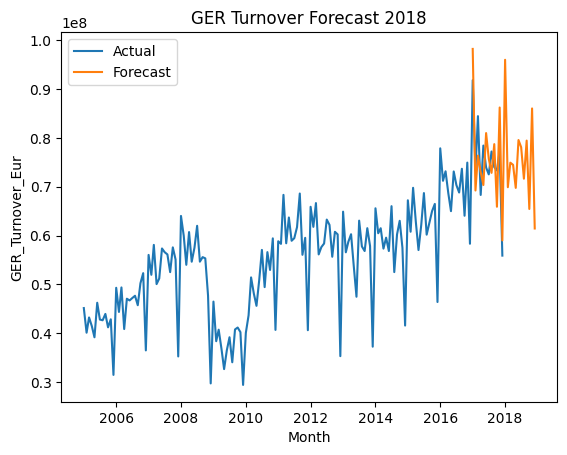

In [152]:
plt.plot(ger['Month'].iloc[:-12],ger['GER_Turnover_eur'].iloc[:-12], label='Actual')
plt.plot(ger.iloc[-24:]['Month'],ger_df_results.iloc[-24:]['y_forecast'], label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('GER_Turnover_Eur')
plt.title('GER Turnover Forecast 2018')

### 8 Italy

In [153]:
ita.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Month             228 non-null    datetime64[ns]
 1   ITA_GDP_EUR       228 non-null    int64         
 2   ITA_Turnover_eur  216 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.5 KB


In [154]:
ita_tmpdf = granger_test(ita)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=31.2460 , p=0.0000  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=31.6881 , p=0.0000  , df=1
likelihood ratio test: chi2=29.5597 , p=0.0000  , df=1
parameter F test:         F=31.2460 , p=0.0000  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=6.2469  , p=0.0023  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=12.7926 , p=0.0017  , df=2
likelihood ratio test: chi2=12.4249 , p=0.0020  , df=2
parameter F test:         F=6.2469  , p=0.0023  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.3302  , p=0.0754  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=7.2281  , p=0.0650  , df=3
likelihood ratio test: chi2=7.1081  , p=0.0685  , df=3
parameter F test:         F=2.3302  , p=0.0754  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.4707  , p=0.0459  

In [155]:
ita_train, ita_test = ita_tmpdf[ita_tmpdf.index.year<2017],ita_tmpdf[ita_tmpdf.index.year==2017]


In [156]:
for c in ita_train.columns:
    adfuller_test(ita_train[c])

ADF Statistic: 0.6985
p-value: 0.9898
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -2.0045
p-value: 0.2846
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
Result: Series is non-stationary (fail to reject null hypothesis)


In [157]:
ita_tmpdf_diff = ita_train.diff().dropna()

In [158]:
for c in ita_tmpdf_diff.columns:
    adfuller_test(ita_tmpdf_diff[c])

ADF Statistic: -2.6952
p-value: 0.0749
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -4.2247
p-value: 0.0006
Critical Values:
   1%: -3.4635
   5%: -2.8761
   10%: -2.5745
Result: Series is stationary (reject null hypothesis)


In [159]:
ita_tmpdf_diff = ita_tmpdf_diff.diff().dropna()

In [160]:
for c in ita_tmpdf_diff.columns:
    adfuller_test(ita_tmpdf_diff[c])

ADF Statistic: -13.3785
p-value: 0.0000
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -10.6087
p-value: 0.0000
Critical Values:
   1%: -3.4640
   5%: -2.8763
   10%: -2.5747
Result: Series is stationary (reject null hypothesis)


rejecting the null hypothesis, stationary

In [161]:
ita_model = VAR(ita_tmpdf_diff)
x = ita_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,74.80,74.84,3.068e+32,74.82
1,73.82,73.93,1.149e+32,73.86
2,72.78,72.96,4.066e+31,72.86
3,72.38,72.63,2.727e+31,72.48
4,72.13,72.45,2.107e+31,72.26
5,72.06,72.45,1.968e+31,72.22
6,72.08,72.55,2.021e+31,72.27
7,71.98,72.52,1.821e+31,72.20
8,71.95,72.56,1.768e+31,72.20
9,71.88,72.56,1.659e+31,72.16


In [162]:
ita_model_fitted = ita_model.fit(13)
lag_order = ita_model_fitted.k_ar
print(lag_order)  

13


In [163]:
ita_forecast_input = ita_tmpdf_diff.values[-lag_order:]


In [164]:
nobs=24
fc = ita_model_fitted.forecast(y=ita_forecast_input, steps=24)
ita_df_forecast = pd.DataFrame(fc, index=ita['Month'].iloc[-24:], columns=ita_tmpdf.columns)
ita_df_forecast

,y,x
Month,,
2017-01-01,7.289683e+06,1.040385e+09
2017-02-01,2.753566e+06,-5.672383e+08
2017-03-01,-1.172430e+06,-1.648749e+08
2017-04-01,-2.162582e+06,1.940622e+09
2017-05-01,8.715314e+05,-2.333644e+09
2017-06-01,-1.873781e+06,5.878562e+08
2017-07-01,3.753127e+05,1.282928e+09
2017-08-01,-1.134975e+07,-1.672846e+09
2017-09-01,2.876721e+07,6.963295e+08


In [165]:
def ita_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [166]:
ita_df_results = ita_invert_transformation(ita_train.iloc[-24:], ita_df_forecast)       

In [167]:
ita_actual_turnover = ita[ita['Month'].dt.year>=2017].iloc[:12]['y']
ita_pred_turnover = ita_df_results.iloc[:12]['y_forecast']

In [168]:
np.sqrt(mean_squared_error(ita_actual_turnover.values,ita_pred_turnover.values))

6942222.9010344045

In [169]:
ita_mape = mean_absolute_percentage_error(ita_actual_turnover.values,ita_pred_turnover.values)*100
print(f'ITA MAPE:{ita_mape:.2f}%')

ITA MAPE:22.93%


Text(0.5, 1.0, 'ITA Turnover Forecast 2018')

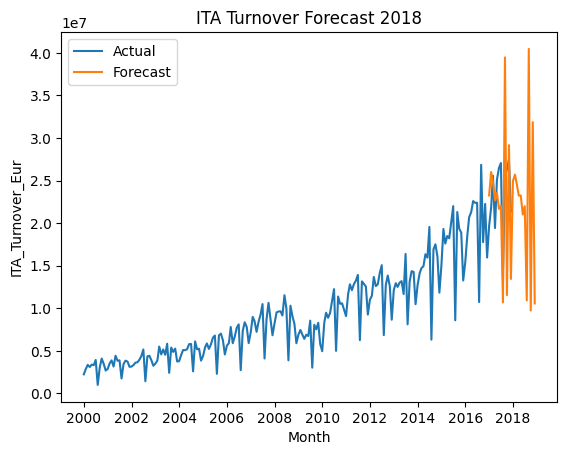

In [170]:
plt.plot(ita['Month'].iloc[:-12],ita['y'].iloc[:-12],label='Actual')
plt.plot(ita['Month'].iloc[-24:],ita_df_results.iloc[-24:]['y_forecast'],label='Forecast')
plt.legend()
plt.xlabel('Month')
plt.ylabel('ITA_Turnover_Eur')
plt.title('ITA Turnover Forecast 2018')

### 10. JAPAN

In [171]:
jp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 4 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Month                         228 non-null    datetime64[ns]
 1   JP_Machine_orders_in_mil_Yen  165 non-null    float64       
 2   JP_GDP_eur                    168 non-null    float64       
 3   JP_Turnover_eur               156 non-null    float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 7.2 KB


In [172]:
jp = jp.dropna(subset='JP_GDP_eur')
jp.head()

,Month,JP_Machine_orders_in_mil_Yen,JP_GDP_eur,JP_Turnover_eur
60,2005-01-01,NaN,947.77302,9.807964e+06
61,2005-02-01,NaN,947.77302,1.104396e+07
62,2005-03-01,NaN,947.77302,1.042028e+07
63,2005-04-01,2.165755e+06,959.95201,1.138539e+07
64,2005-05-01,2.069604e+06,959.95201,1.072680e+07


In [173]:
jp.corr()

,Month,JP_Machine_orders_in_mil_Yen,JP_GDP_eur,JP_Turnover_eur
Month,1.000000,0.122058,0.524697,0.498593
JP_Machine_orders_in_mil_Yen,0.122058,1.000000,-0.243506,0.641811
JP_GDP_eur,0.524697,-0.243506,1.000000,0.194095
JP_Turnover_eur,0.498593,0.641811,0.194095,1.000000


In [174]:
jp_tmpdf = granger_test(jp[['Month','JP_GDP_eur','JP_Turnover_eur']])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.5566  , p=0.4568  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=0.5676  , p=0.4512  , df=1
likelihood ratio test: chi2=0.5666  , p=0.4516  , df=1
parameter F test:         F=0.5566  , p=0.4568  , df_denom=152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.6410  , p=0.5282  , df_denom=149, df_num=2
ssr based chi2 test:   chi2=1.3251  , p=0.5155  , df=2
likelihood ratio test: chi2=1.3195  , p=0.5170  , df=2
parameter F test:         F=0.6410  , p=0.5282  , df_denom=149, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=4.0932  , p=0.0080  , df_denom=146, df_num=3
ssr based chi2 test:   chi2=12.8684 , p=0.0049  , df=3
likelihood ratio test: chi2=12.3558 , p=0.0063  , df=3
parameter F test:         F=4.0932  , p=0.0080  , df_denom=146, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=3.2630  , p=0.0135  

In [175]:
jp_train, jp_test = jp_tmpdf[jp_tmpdf.index.year<2017],jp_tmpdf[jp_tmpdf.index.year==2017]

In [176]:
for c in jp_train.columns:
    adfuller_test(jp_train[c])

ADF Statistic: -2.1409
p-value: 0.2284
Critical Values:
   1%: -3.4813
   5%: -2.8839
   10%: -2.5787
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -1.8322
p-value: 0.3646
Critical Values:
   1%: -3.4813
   5%: -2.8839
   10%: -2.5787
Result: Series is non-stationary (fail to reject null hypothesis)


In [177]:
jp_tmpdf_diff = jp_train.diff().dropna()

In [178]:
for c in jp_tmpdf_diff.columns:
    adfuller_test(jp_tmpdf_diff[c])

ADF Statistic: -3.0363
p-value: 0.0316
Critical Values:
   1%: -3.4825
   5%: -2.8844
   10%: -2.5790
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -2.4606
p-value: 0.1254
Critical Values:
   1%: -3.4813
   5%: -2.8839
   10%: -2.5787
Result: Series is non-stationary (fail to reject null hypothesis)


rejecting null hypothesis, stationary

In [179]:
jp_model = VAR(jp_tmpdf_diff)
x = jp_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,35.24,35.29*,2.015e+15,35.26
1,35.21,35.35,1.952e+15,35.26
2,35.15*,35.38,1.834e+15*,35.24*
3,35.18,35.51,1.906e+15,35.32
4,35.24,35.66,2.026e+15,35.42
5,35.31,35.82,2.160e+15,35.52
6,35.37,35.98,2.297e+15,35.62
7,35.40,36.10,2.370e+15,35.68
8,35.44,36.23,2.468e+15,35.76
9,35.48,36.36,2.568e+15,35.84


In [180]:
jp_model_fitted = jp_model.fit(12)
lag_order = jp_model_fitted.k_ar
print(lag_order)  

12


In [181]:
jp_forecast_input = jp_tmpdf_diff.values[-lag_order:]
jp_forecast_input

array([[-1.99585433e+05,  8.48829000e+01],
       [ 2.24082145e+06,  0.00000000e+00],
       [-1.06733737e+06,  0.00000000e+00],
       [ 8.19666879e+04, -1.27882000e+01],
       [-7.30530166e+05,  0.00000000e+00],
       [ 5.54990892e+05,  0.00000000e+00],
       [-1.30044523e+05, -1.35356000e+01],
       [-4.82897822e+05,  0.00000000e+00],
       [ 1.22745134e+06,  0.00000000e+00],
       [ 1.16288279e+06,  7.48194000e+01],
       [-4.63016854e+04,  0.00000000e+00],
       [-1.63520674e+06,  0.00000000e+00]])

In [182]:
nobs=24
fc = jp_model_fitted.forecast(y=jp_forecast_input, steps=24)
jp_df_forecast = pd.DataFrame(fc, index=jp['Month'].iloc[-24:], columns=jp_tmpdf.columns)
jp_df_forecast

,y,x
Month,,
2017-01-01,8.296646e+05,22.974468
2017-02-01,1.008719e+06,8.166914
2017-03-01,-6.885259e+05,18.658811
2017-04-01,1.050903e+05,-7.111523
2017-05-01,-3.197514e+05,6.717612
2017-06-01,5.155756e+05,-1.091215
2017-07-01,-2.457929e+05,-15.307477
2017-08-01,-5.016023e+05,-3.455282
2017-09-01,7.896222e+05,0.522054


In [183]:
def jp_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [184]:
jp_df_results = jp_invert_transformation(jp_train.iloc[-24:], jp_df_forecast)       

In [185]:
jp_actual_turnover = jp[jp['Month'].dt.year>=2017].iloc[:12]['JP_Turnover_eur']
jp_pred_turnover = jp_df_results.iloc[:12]['y_forecast']

In [186]:
np.sqrt(mean_squared_error(jp_actual_turnover.values,jp_pred_turnover.values))

1341697.664152624

In [187]:
jp_mape = mean_absolute_percentage_error(jp_actual_turnover.values,jp_pred_turnover.values)*100
print(f'JP MAPE:{gbr_mape:.2f}%')

JP MAPE:8.19%


Text(0.5, 1.0, 'JP Turnover Forecast 2018')

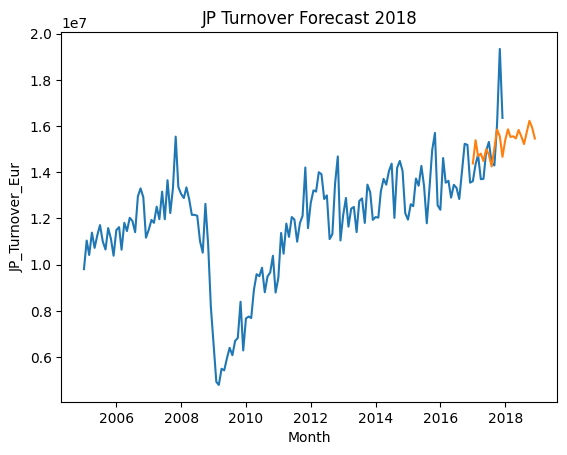

In [188]:
plt.plot(jp['Month'].iloc[:-12],jp['JP_Turnover_eur'].iloc[:-12])
plt.plot(jp['Month'].iloc[-24:],jp_df_results.iloc[-24:]['y_forecast'])
plt.xlabel('Month')
plt.ylabel('JP_Turnover_Eur')
plt.title('JP Turnover Forecast 2018')

### 11. NEDERLAND

In [189]:
ned = ned.dropna(subset='NED_GDP_eur')

In [190]:
ned.corr()

,Month,NED_Producer_confidence,NED_GDP_eur,NED_Turnover_eur
Month,1.000000,0.817010,0.947748,0.917080
NED_Producer_confidence,0.817010,1.000000,0.834774,0.673477
NED_GDP_eur,0.947748,0.834774,1.000000,0.874706
NED_Turnover_eur,0.917080,0.673477,0.874706,1.000000


In [191]:
ned_tmpdf = granger_test(ned[['Month','NED_GDP_eur','NED_Turnover_eur']])


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=28.1488 , p=0.0000  , df_denom=152, df_num=1
ssr based chi2 test:   chi2=28.7044 , p=0.0000  , df=1
likelihood ratio test: chi2=26.3349 , p=0.0000  , df=1
parameter F test:         F=28.1488 , p=0.0000  , df_denom=152, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=7.3676  , p=0.0009  , df_denom=149, df_num=2
ssr based chi2 test:   chi2=15.2297 , p=0.0005  , df=2
likelihood ratio test: chi2=14.5229 , p=0.0007  , df=2
parameter F test:         F=7.3676  , p=0.0009  , df_denom=149, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.4571  , p=0.0653  , df_denom=146, df_num=3
ssr based chi2 test:   chi2=7.7247  , p=0.0521  , df=3
likelihood ratio test: chi2=7.5360  , p=0.0566  , df=3
parameter F test:         F=2.4571  , p=0.0653  , df_denom=146, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=1.9851  , p=0.0999  

In [192]:
ned_train, ned_test = ned_tmpdf[ned_tmpdf.index.year<2017],ned_tmpdf[ned_tmpdf.index.year==2017]

In [193]:
for c in ned_train.columns:
    adfuller_test(ned_train[c])

ADF Statistic: 0.5498
p-value: 0.9863
Critical Values:
   1%: -3.4809
   5%: -2.8837
   10%: -2.5786
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -1.3863
p-value: 0.5888
Critical Values:
   1%: -3.4779
   5%: -2.8824
   10%: -2.5779
Result: Series is non-stationary (fail to reject null hypothesis)


In [194]:
ned_tmpdf_diff = ned_train.diff().dropna()

In [195]:
for c in ned_tmpdf_diff.columns:
    adfuller_test(ned_tmpdf_diff[c])

ADF Statistic: -4.5037
p-value: 0.0002
Critical Values:
   1%: -3.4813
   5%: -2.8839
   10%: -2.5787
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -3.8125
p-value: 0.0028
Critical Values:
   1%: -3.4779
   5%: -2.8824
   10%: -2.5779
Result: Series is stationary (reject null hypothesis)


Rejecting the null- hypothesis, stationary


In [196]:
ned_model = VAR(ned_tmpdf_diff)
x = ned_model.select_order(maxlags=30)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.06,68.11,3.607e+29,68.08
1,67.94,68.08,3.193e+29,67.99
2,67.82,68.06,2.848e+29,67.92
3,67.46,67.80*,1.979e+29,67.59*
4,67.45,67.88,1.961e+29,67.62
5,67.47,68.00,2.012e+29,67.69
6,67.45,68.08,1.964e+29,67.70
7,67.50,68.22,2.069e+29,67.79
8,67.53,68.35,2.146e+29,67.87
9,67.55,68.47,2.195e+29,67.93


In [197]:
ned_model_fitted = ned_model.fit(12)
lag_order = ned_model_fitted.k_ar
print(lag_order) 

12


In [198]:
ned_forecast_input = ned_tmpdf_diff.values[-lag_order:]
ned_forecast_input

array([[ 9.10560747e+05,  9.30000000e+08],
       [ 5.04010580e+05,  0.00000000e+00],
       [ 8.64020544e+05,  0.00000000e+00],
       [-5.89208680e+05,  1.18000000e+09],
       [-7.13268016e+05,  0.00000000e+00],
       [ 9.26665127e+05,  0.00000000e+00],
       [-7.53765474e+05,  2.01000000e+09],
       [ 6.49082364e+05,  0.00000000e+00],
       [ 6.81406812e+04,  0.00000000e+00],
       [ 6.72164261e+05,  1.73000000e+09],
       [-1.22412103e+05,  0.00000000e+00],
       [-1.54336916e+06,  0.00000000e+00]])

In [199]:
nobs=24
fc = ned_model_fitted.forecast(y=ned_forecast_input, steps=24)
ned_df_forecast = pd.DataFrame(fc, index=ned['Month'].iloc[-24:], columns=ned_tmpdf.columns)
ned_df_forecast

,y,x
Month,,
2017-01-01,797853.879060,9.831054e+08
2017-02-01,456773.654283,3.859746e+08
2017-03-01,224398.375115,-1.340065e+08
2017-04-01,-178715.979379,9.889602e+08
2017-05-01,-488356.368349,1.535704e+08
2017-06-01,644938.191873,-3.914423e+08
2017-07-01,-416028.313326,1.118479e+09
2017-08-01,2003.316212,2.171020e+08
2017-09-01,256216.856703,-8.653621e+07


In [200]:
def ned_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [201]:
ned_df_results = ned_invert_transformation(ned_train.iloc[-24:], ned_df_forecast)       

In [202]:
ned_actual_turnover = ned[ned['Month'].dt.year>=2017].iloc[:12]['NED_Turnover_eur']
ned_pred_turnover = ned_df_results.iloc[:12]['y_forecast']

In [203]:
np.sqrt(mean_squared_error(ned_actual_turnover.values,ned_pred_turnover.values))

583312.5802151188

In [204]:
ned_mape = mean_absolute_percentage_error(ned_actual_turnover.values,ned_pred_turnover.values)*100
print(f'NED MAPE:{ned_mape:.2f}%')

NED MAPE:6.80%


Text(0.5, 1.0, 'NED Turnover Forecast 2018')

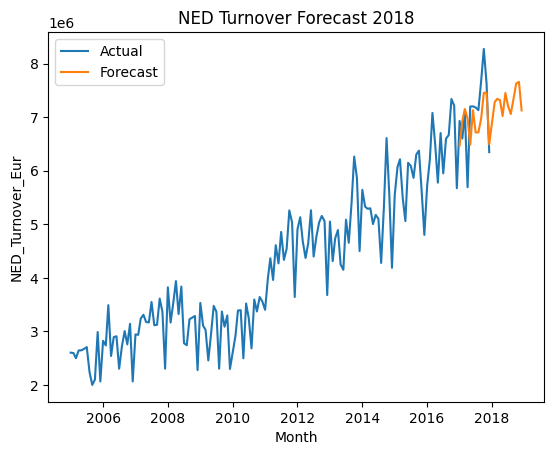

In [205]:
plt.plot(ned['Month'].iloc[:-12],ned['NED_Turnover_eur'].iloc[:-12], label='Actual')
plt.plot(ned['Month'].iloc[-24:],ned_df_results.iloc[-24:]['y_forecast'], label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('NED_Turnover_Eur')
plt.title('NED Turnover Forecast 2018')

### 12. SWEDEN

In [206]:
swe.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Month             228 non-null    datetime64[ns]
 1   SWE_GDP_EUR       228 non-null    int64         
 2   SWE_Turnover_eur  216 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.5 KB


In [207]:
swe_tmpdf = granger_test(swe)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=101.0646, p=0.0000  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=102.4948, p=0.0000  , df=1
likelihood ratio test: chi2=83.8120 , p=0.0000  , df=1
parameter F test:         F=101.0646, p=0.0000  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=42.0599 , p=0.0000  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=86.1322 , p=0.0000  , df=2
likelihood ratio test: chi2=72.3849 , p=0.0000  , df=2
parameter F test:         F=42.0599 , p=0.0000  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=23.3255 , p=0.0000  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=72.3544 , p=0.0000  , df=3
likelihood ratio test: chi2=62.2897 , p=0.0000  , df=3
parameter F test:         F=23.3255 , p=0.0000  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=17.0807 , p=0.0000  

In [208]:
swe_train, swe_test = swe_tmpdf[swe_tmpdf.index.year<2017],swe_tmpdf[swe_tmpdf.index.year==2017]

In [209]:
for c in swe_train.columns:
    adfuller_test(swe_train[c])

ADF Statistic: -0.6563
p-value: 0.8578
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: -0.4545
p-value: 0.9006
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)


In [210]:
swe_tmpdf_diff = swe_train.diff().dropna()

In [211]:
for c in swe_tmpdf_diff.columns:
    adfuller_test(swe_tmpdf_diff[c])

ADF Statistic: -3.8862
p-value: 0.0021
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -4.9076
p-value: 0.0000
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is stationary (reject null hypothesis)


Rejecting the null hypothesis, stationary

In [212]:
swe_model = VAR(swe_tmpdf_diff)
x = swe_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,68.70,68.74,6.882e+29,68.72
1,68.64,68.74,6.429e+29,68.68
2,68.57,68.74,5.991e+29,68.64
3,68.42,68.67,5.188e+29,68.52
4,68.08,68.40,3.681e+29,68.21
5,68.06,68.45,3.616e+29,68.22
6,67.86,68.32,2.950e+29,68.04
7,67.87,68.40,2.988e+29,68.09
8,67.90,68.51,3.090e+29,68.15
9,67.84,68.52,2.913e+29,68.12


In [213]:
swe_model_fitted = swe_model.fit(15)
lag_order = swe_model_fitted.k_ar
print(lag_order)  

15


In [214]:
swe_forecast_input = swe_tmpdf_diff.values[-lag_order:]
swe_forecast_input

array([[-2.30667578e+05,  2.75000000e+09],
       [-4.57966574e+05,  0.00000000e+00],
       [-4.38600733e+05,  0.00000000e+00],
       [ 2.85097433e+05, -2.80000000e+08],
       [ 2.29746672e+05,  0.00000000e+00],
       [ 6.85282196e+05,  0.00000000e+00],
       [-1.12290184e+05,  1.38000000e+09],
       [-1.86410912e+05,  0.00000000e+00],
       [-1.20903280e+05,  0.00000000e+00],
       [-1.74663087e+06, -1.80000000e+09],
       [ 1.62251019e+06,  0.00000000e+00],
       [ 3.58607124e+05,  0.00000000e+00],
       [-1.50387816e+04, -6.70000000e+08],
       [ 2.12332154e+05,  0.00000000e+00],
       [-6.79737978e+05,  0.00000000e+00]])

In [215]:
nobs=24
fc = swe_model_fitted.forecast(y=swe_forecast_input, steps=24)
swe_df_forecast = pd.DataFrame(fc, index=swe['Month'].iloc[-24:], columns=swe_tmpdf.columns)
swe_df_forecast

,y,x
Month,,
2017-01-01,-7.965482e+04,-7.602281e+08
2017-02-01,-1.392140e+04,-8.572128e+08
2017-03-01,4.322223e+05,-5.650194e+08
2017-04-01,1.272465e+05,1.305913e+09
2017-05-01,-1.230667e+05,-3.639863e+08
2017-06-01,-1.356479e+05,7.036267e+07
2017-07-01,-1.367165e+06,7.970883e+08
2017-08-01,1.224954e+06,-6.031750e+08
2017-09-01,3.207730e+05,-4.096112e+08


In [216]:
def swe_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [217]:
swe_df_results = swe_invert_transformation(swe_train.iloc[-24:], swe_df_forecast)       

In [218]:
swe_actual_turnover = swe[swe['Month'].dt.year>=2017].iloc[:12]['y']
swe_pred_turnover = swe_df_results.iloc[:12]['y_forecast']

In [219]:
np.sqrt(mean_squared_error(swe_actual_turnover.values,swe_pred_turnover.values))

737485.722587873

In [220]:
swe_mape = mean_absolute_percentage_error(swe_actual_turnover.values,swe_pred_turnover.values)*100
print(f'SWE MAPE:{swe_mape:.2f}%')

SWE MAPE:14.76%


Text(0.5, 1.0, 'SWE Turnover Forecast 2018')

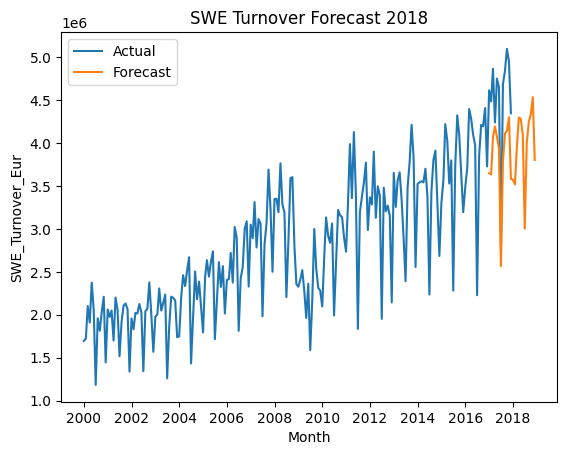

In [221]:
plt.plot(swe['Month'].iloc[:-12],swe['y'].iloc[:-12],label='Actual')
plt.plot(swe['Month'].iloc[-24:],swe_df_results.iloc[-24:]['y_forecast'],label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('SWE_Turnover_Eur')
plt.title('SWE Turnover Forecast 2018')

### 13. USA

In [222]:
usa.head()

,Month,USA_GDP_USD,USA_Turnover_eur
0,2000-01-01,992600000000,4.275446e+06
1,2000-02-01,999600000000,4.433853e+06
2,2000-03-01,1009000000000,4.277618e+06
3,2000-04-01,1022000000000,3.592345e+06
4,2000-05-01,1023000000000,4.239386e+06


In [223]:
usa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228 entries, 0 to 227
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Month             228 non-null    datetime64[ns]
 1   USA_GDP_USD       228 non-null    int64         
 2   USA_Turnover_eur  216 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 5.5 KB


In [224]:
usa_tmpdf = granger_test(usa)


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=29.6689 , p=0.0000  , df_denom=212, df_num=1
ssr based chi2 test:   chi2=30.0888 , p=0.0000  , df=1
likelihood ratio test: chi2=28.1612 , p=0.0000  , df=1
parameter F test:         F=29.6689 , p=0.0000  , df_denom=212, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=5.7094  , p=0.0039  , df_denom=209, df_num=2
ssr based chi2 test:   chi2=11.6920 , p=0.0029  , df=2
likelihood ratio test: chi2=11.3838 , p=0.0034  , df=2
parameter F test:         F=5.7094  , p=0.0039  , df_denom=209, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=2.9219  , p=0.0350  , df_denom=206, df_num=3
ssr based chi2 test:   chi2=9.0637  , p=0.0285  , df=3
likelihood ratio test: chi2=8.8762  , p=0.0310  , df=3
parameter F test:         F=2.9219  , p=0.0350  , df_denom=206, df_num=3

Granger Causality
number of lags (no zero) 4
ssr based F test:         F=2.7441  , p=0.0296  

In [225]:
usa_train, usa_test = usa_tmpdf[usa_tmpdf.index.year<2017],usa_tmpdf[usa_tmpdf.index.year==2017]

In [226]:
for c in usa_train.columns:
    adfuller_test(usa_train[c])

ADF Statistic: -0.4442
p-value: 0.9025
Critical Values:
   1%: -3.4654
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)
ADF Statistic: 0.1279
p-value: 0.9679
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)


In [227]:
usa_tmpdf_diff = usa_train.diff().dropna()

In [228]:
for c in usa_tmpdf_diff.columns:
    adfuller_test(usa_tmpdf_diff[c])

ADF Statistic: -2.9515
p-value: 0.0397
Critical Values:
   1%: -3.4658
   5%: -2.8771
   10%: -2.5751
Result: Series is stationary (reject null hypothesis)
ADF Statistic: -2.8606
p-value: 0.0501
Critical Values:
   1%: -3.4656
   5%: -2.8770
   10%: -2.5750
Result: Series is non-stationary (fail to reject null hypothesis)


Rejecting the null-hypothesis, stationary

In [229]:
usa_model = VAR(usa_tmpdf_diff)
x = usa_model.select_order(maxlags=24)
x.summary()

,AIC,BIC,FPE,HQIC
0,72.55,72.59,3.235e+31,72.57
1,72.19,72.29,2.237e+31,72.23
2,72.10,72.27*,2.048e+31,72.17
3,72.09,72.34,2.035e+31,72.19
4,72.03,72.35,1.920e+31,72.16
5,72.06,72.46,1.981e+31,72.22
6,72.10,72.56,2.057e+31,72.29
7,72.09,72.63,2.045e+31,72.31
8,72.09,72.70,2.038e+31,72.34
9,72.13,72.80,2.113e+31,72.40


In [230]:
usa_model_fitted = usa_model.fit(14)
lag_order = usa_model_fitted.k_ar
print(lag_order)  #> 4

14


In [231]:
usa_forecast_input = usa_tmpdf_diff.values[-lag_order:]
usa_forecast_input

array([[-1.21955291e+06, -5.00000000e+09],
       [ 3.28567835e+05,  4.00000000e+09],
       [ 6.52145381e+05,  1.00000000e+09],
       [ 3.64597186e+05, -1.00000000e+09],
       [ 4.61525788e+05,  1.90000000e+10],
       [-7.99131599e+05,  6.00000000e+09],
       [ 4.01173360e+05,  0.00000000e+00],
       [ 4.46340602e+05,  8.00000000e+09],
       [-1.25032975e+06, -1.00000000e+09],
       [ 1.66553860e+06,  1.50000000e+10],
       [-2.91880846e+05,  9.00000000e+09],
       [-3.24756781e+05, -5.00000000e+09],
       [-7.67286991e+05,  1.50000000e+10],
       [ 5.31649537e+05,  7.00000000e+09]])

In [232]:
nobs=24
fc = usa_model_fitted.forecast(y=usa_forecast_input, steps=24)
usa_df_forecast = pd.DataFrame(fc, index=usa['Month'].iloc[-24:], columns=usa_tmpdf.columns)
usa_df_forecast

,y,x
Month,,
2017-01-01,3.670726e+05,1.094593e+09
2017-02-01,4.751239e+05,1.210232e+10
2017-03-01,3.132377e+05,4.489168e+09
2017-04-01,-8.928513e+05,1.689796e+09
2017-05-01,4.972408e+05,1.057580e+10
2017-06-01,-1.202047e+05,3.458171e+09
2017-07-01,-3.519495e+05,3.387813e+09
2017-08-01,1.269062e+06,7.714454e+09
2017-09-01,-8.089279e+05,3.782528e+09


In [233]:
def usa_invert_transformation(df_train, df_forecast):
    """Revert back the differencing to get the forecast to original scale."""
    df_fc = df_forecast.copy()
    columns = df_train.columns
    for col in columns:        
        # Roll back 1st Diff
        df_fc[str(col)+'_forecast'] = df_train[col].iloc[-1] + df_fc[str(col)].cumsum()
    return df_fc

In [234]:
usa_df_results = usa_invert_transformation(usa_train.iloc[-24:], usa_df_forecast)       

In [235]:
usa_actual_turnover = usa[usa['Month'].dt.year>=2017].iloc[:12]['y']
usa_pred_turnover = usa_df_results.iloc[:12]['y_forecast']

In [236]:
np.sqrt(mean_squared_error(usa_actual_turnover.values,usa_pred_turnover.values))

888036.4215151293

In [237]:
usa_mape = mean_absolute_percentage_error(usa_actual_turnover.values,usa_pred_turnover.values)*100
print(f'USA MAPE:{usa_mape:.2f}%')

USA MAPE:7.11%


Text(0.5, 1.0, 'USA Turnover Forecast 2018')

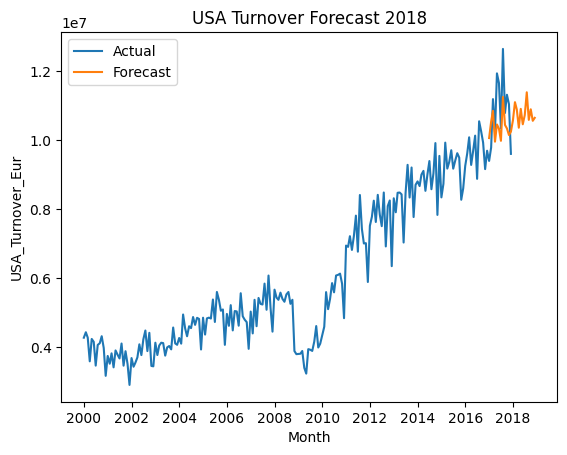

In [238]:
plt.plot(usa['Month'].iloc[:-12],usa['y'].iloc[:-12],label='Actual')
plt.plot(usa['Month'].iloc[-24:],usa_df_results.iloc[-24:]['y_forecast'], label='Forecast')
plt.xlabel('Month')
plt.legend()
plt.ylabel('USA_Turnover_Eur')
plt.title('USA Turnover Forecast 2018')